# Pré-processamento base REDD - Low Frequency

Neste documento será realizada a tabulação dos dados para cliassificação de cargas da base REDD.

A janela considerada será de 5 minutos (3000 segundos).

Procedimentos experimentais baseados em http://www.sbrt.org.br/sbrt2017/anais/1570359866.pdf

In [1]:
import warnings
#warnings.filterwarnings("warning")

import time
import tensorflow as tf

#tf.debugging.set_log_device_placement(True)
#print("GPU Available: ", tf.test.is_gpu_available())

## Carregando os dados da base REDD via NILMTK

In [2]:
from nilmtk import DataSet
from nilmtk.utils import print_dict

redd = DataSet('datasets/REDD/low_freq.h5')

C:\Users\diego\anaconda3\envs\doutorado\lib\site-packages\nilm_metadata\file_management.py:16: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  objs = yaml.load(fh)


# Explorando o objeto de dados  `REDD`

## Meta-dados

Primeiramente, é possível acessar os metadados do dataset, incluindo as informações sobre os dois modelos de medidores utilizados para a coleta dos dados:

In [3]:
print_dict(redd.metadata)

É possível também acessar informações das residências em um objeto do tipo [OrderedDict](https://docs.python.org/2/library/collections.html#collections.OrderedDict) (indexado a partir de 1 porque todo dataset no NILMTK inicia o índice de `buildings`em 1 e não 0)

In [4]:
print_dict(redd.buildings)

Cara residência possui algumas informações de metadata: para nosso pré-processamento, vamos utilizar a `residência 2`:

In [5]:
building_idx = 2

In [6]:
print_dict(redd.buildings[building_idx].metadata)

Ainda, cada residência possui um atributo `elec` que é o objeto `MeterGroup` (de fato, os medidores do tipo `plug`utilizado na mediçção de cada um dos dispositivos contemplados):

In [7]:
elec = redd.buildings[building_idx].elec
elec

MeterGroup(meters=
  ElecMeter(instance=1, building=2, dataset='REDD', site_meter, appliances=[])
  ElecMeter(instance=2, building=2, dataset='REDD', site_meter, appliances=[])
  ElecMeter(instance=3, building=2, dataset='REDD', appliances=[Appliance(type='sockets', instance=1)])
  ElecMeter(instance=4, building=2, dataset='REDD', appliances=[Appliance(type='light', instance=1)])
  ElecMeter(instance=5, building=2, dataset='REDD', appliances=[Appliance(type='electric stove', instance=1)])
  ElecMeter(instance=6, building=2, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])
  ElecMeter(instance=7, building=2, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=8, building=2, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])
  ElecMeter(instance=9, building=2, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])
  ElecMeter(instance=10, building=2, dataset='REDD', appliances=[Appliance(type='dis

In [8]:
elec.mains()

MeterGroup(meters=
  ElecMeter(instance=1, building=2, dataset='REDD', site_meter, appliances=[])
  ElecMeter(instance=2, building=2, dataset='REDD', site_meter, appliances=[])
)

Neste caso, é possível capturar os dados de energia de ambas as correntes principais somadas:

In [9]:
elec.mains().power_series_all_data().head()

Loading data for meter ElecMeterID(instance=2, building=2, dataset='REDD')     
Done loading data all meters for this chunk.


2011-04-17 19:18:27-04:00    306.809998
2011-04-17 19:18:28-04:00    306.319977
2011-04-17 19:18:29-04:00    306.400024
2011-04-17 19:18:30-04:00    305.760010
2011-04-17 19:18:31-04:00    321.360016
Name: (power, apparent), dtype: float32

No caso das medições individuais dos dispositivos:

In [10]:
elec.submeters()

MeterGroup(meters=
  ElecMeter(instance=3, building=2, dataset='REDD', appliances=[Appliance(type='sockets', instance=1)])
  ElecMeter(instance=4, building=2, dataset='REDD', appliances=[Appliance(type='light', instance=1)])
  ElecMeter(instance=5, building=2, dataset='REDD', appliances=[Appliance(type='electric stove', instance=1)])
  ElecMeter(instance=6, building=2, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])
  ElecMeter(instance=7, building=2, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=8, building=2, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])
  ElecMeter(instance=9, building=2, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])
  ElecMeter(instance=10, building=2, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])
  ElecMeter(instance=11, building=2, dataset='REDD', appliances=[Appliance(type='waste disposal unit', instance=1)])
)

## Estatísticas para os `MeterGroups`

### Proporção de energia submedida

Vamos verificar a proporção de energia submedida na residência 1:

In [11]:
elec.proportion_of_energy_submetered()

Running MeterGroup.proportion_of_energy_submetered...
Calculating total_energy for ElecMeterID(instance=2, building=2, dataset='REDD') ...   

c:\users\diego\desktop\doutorado\nilmtk-repo\nilmtk\metergroup.py:935: UserWarning: As a quick implementation we only get Good Sections from the first meter in the meter group.  We should really return the intersection of the good sections for all meters.  This will be fixed...
  warnings.warn("As a quick implementation we only get Good Sections from"


Calculating total_energy for ElecMeterID(instance=1, building=2, dataset='REDD') ...   

c:\users\diego\desktop\doutorado\nilmtk-repo\nilmtk\electric.py:307: UserWarning: No shared AC types.  Using 'active' for submeter and 'apparent' for other.
  " and '{:s}' for other.".format(ac_type, other_ac_type))


Calculating total_energy for ElecMeterID(instance=2, building=2, dataset='REDD') ...   

0.652525752001292

### Potência ativa, reativa e aparente

Vamos verificar os tipos de medida de energia que foram usadas para as medições (correntes principais e dispositivos):

In [12]:
mains = elec.mains() # Correntes principais
mains.available_ac_types('power')

['apparent']

In [13]:
elec.submeters().available_ac_types('power') # Dispositivos

['active']

In [14]:
#next(elec.load()) # Verificando os dispositivos

# resample to 6s (i.e. with a sample period of 60 secs)
df = next(elec.load(sample_period=6))

#df = next(fridge.load(ac_type='active', sample_period=60))

Loading data for meter ElecMeterID(instance=11, building=2, dataset='REDD')     
Done loading data all meters for this chunk.


In [15]:
df

physical_quantity                power       
type                          apparent active
2011-04-17 19:18:24-04:00   306.510010    NaN
2011-04-17 19:18:30-04:00   331.811646    NaN
2011-04-17 19:18:36-04:00   331.811646    NaN
2011-04-17 19:18:42-04:00   331.811646    NaN
2011-04-17 19:18:48-04:00   331.811646    NaN
2011-04-17 19:18:54-04:00   305.916656    NaN
2011-04-17 19:19:00-04:00   306.125000    NaN
2011-04-17 19:19:06-04:00   306.125000    NaN
2011-04-17 19:19:12-04:00   306.125000    NaN
2011-04-17 19:19:18-04:00   306.125000    NaN
2011-04-17 19:19:24-04:00   306.265991    NaN
2011-04-17 19:19:30-04:00   277.803345    NaN
2011-04-17 19:19:36-04:00   322.654968    NaN
2011-04-17 19:19:42-04:00   415.211670    NaN
2011-04-17 19:19:48-04:00   572.716675    NaN
2011-04-17 19:19:54-04:00   667.950012    NaN
2011-04-17 19:20:00-04:00   670.849976    NaN
2011-04-17 19:20:06-04:00   671.734985    NaN
2011-04-17 19:20:12-04:00   673.554993    NaN
2011-04-17 19:20:18-04:00   675.626709    NaN
2011-04-17 19:20:24-04:00   677.198364    NaN
2011-04-17 19:20:30-04:00   679.326660    NaN
2011-04-17 19:20:36-04:00   680.349976    NaN
2011-04-17 19:20:42-04:00   680.808350    NaN
2011-04-17 19:20:48-04:00   680.770020    NaN
2011-04-17 19:20:54-04:00   903.070007    NaN
2011-04-17 19:21:00-04:00  2492.207520    NaN
2011-04-17 19:21:06-04:00  2492.207520    NaN
2011-04-17 19:21:12-04:00  2492.207520    NaN
2011-04-17 19:21:18-04:00  2492.207520    NaN
...                                ...    ...
2011-05-22 19:56:18-04:00   265.355011  175.0
2011-05-22 19:56:24-04:00   265.464996  177.0
2011-05-22 19:56:30-04:00   265.543335  178.0
2011-05-22 19:56:36-04:00   265.473328  175.5
2011-05-22 19:56:42-04:00   265.378326  177.0
2011-05-22 19:56:48-04:00   265.616669  177.0
2011-05-22 19:56:54-04:00   265.584991  176.0
2011-05-22 19:57:00-04:00   265.376648  177.5
2011-05-22 19:57:06-04:00   264.973328  176.0
2011-05-22 19:57:12-04:00   265.043335  178.0
2011-05-22 19:57:18-04:00   264.904999  175.0
2011-05-22 19:57:24-04:00   264.519989  175.5
2011-05-22 19:57:30-04:00   264.529999  178.0
2011-05-22 19:57:36-04:00   264.658325  175.0
2011-05-22 19:57:42-04:00   264.366669  176.0
2011-05-22 19:57:48-04:00   264.125000  175.0
2011-05-22 19:57:54-04:00   264.158325  174.5
2011-05-22 19:58:00-04:00   264.863342  174.5
2011-05-22 19:58:06-04:00   265.158325  174.0
2011-05-22 19:58:12-04:00   264.511658  176.0
2011-05-22 19:58:18-04:00   264.424988  173.0
2011-05-22 19:58:24-04:00   264.161652  174.5
2011-05-22 19:58:30-04:00   264.070007  172.0
2011-05-22 19:58:36-04:00   263.926666  174.0
2011-05-22 19:58:42-04:00   263.523346  173.5
2011-05-22 19:58:48-04:00   263.540009  175.0
2011-05-22 19:58:54-04:00   263.496674  173.5
2011-05-22 19:59:00-04:00   263.764984  174.5
2011-05-22 19:59:06-04:00   263.146667  172.0
2011-05-22 19:59:12-04:00   262.559998    NaN

[504409 rows x 2 columns]

### Energia Total da Residência

In [16]:
elec.mains().total_energy() # kWh

Calculating total_energy for ElecMeterID(instance=2, building=2, dataset='REDD') ...   

apparent    77.222991
dtype: float64

### Energia Total por Submedidor (Dispositivos da Resid. 1)

In [17]:
energy_per_meter = elec.submeters().energy_per_meter() # kWh, again
energy_per_meter

9/9 ElecMeter(instance=11, building=2, dataset='REDD', appliances=[Appliance(type='waste disposal unit', instance=1)])

,"(3, 2, REDD)","(4, 2, REDD)","(5, 2, REDD)","(6, 2, REDD)","(7, 2, REDD)","(8, 2, REDD)","(9, 2, REDD)","(10, 2, REDD)","(11, 2, REDD)"
active,2.066441,8.886603,0.483484,5.141312,0.714265,3.431987,26.634318,2.992981,0.026742
apparent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
reactive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


> NOTA: o cabeçalho se refere aos números de instância dos objetos `ElecMeter`.

### Selecione os medidores com base em seu consumo de energia

In [18]:
# energy_per_meter é um DataFrame onde cada linha é um 
# tipo de energia ('active', 'reactive' or 'apparent').
# Todos os medidores de dispositivo na base REDD registros 
# do tipo 'active', então basta selecionar a linha 'active':
energy_per_meter = energy_per_meter.loc['active']
more_than_20 = energy_per_meter[energy_per_meter > 20]
more_than_20

(9, 2, REDD)    26.634318
Name: active, dtype: float64

In [19]:
instances = more_than_20.index
instances

Index([(9, 2, 'REDD')], dtype='object')

## Gráfico do Consumo de Energia de cada Dispositivo

In [20]:
from matplotlib import rcParams
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')
rcParams['figure.figsize'] = (13, 10)

# Calculando proporção individual
fraction = elec.submeters().fraction_per_meter().dropna()

9/9 ElecMeter(instance=11, building=2, dataset='REDD', appliances=[Appliance(type='waste disposal unit', instance=1)])

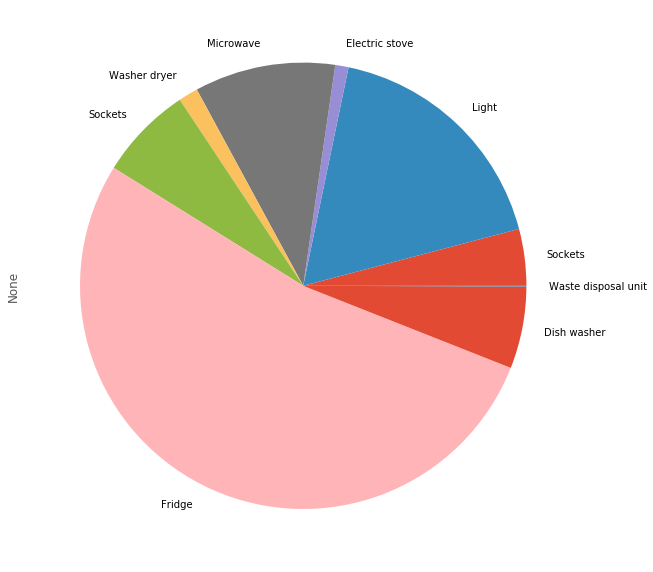

In [21]:
# Criando rótulos
labels = elec.get_labels(fraction.index)
# Plotando o gráfico
plt.figure(figsize=(10,30))
fraction.plot(kind='pie', labels=labels);

### Diagrama Wiring

(<networkx.classes.digraph.DiGraph at 0x1f8000350f0>,
 <matplotlib.axes._axes.Axes at 0x1f800ba2eb8>)

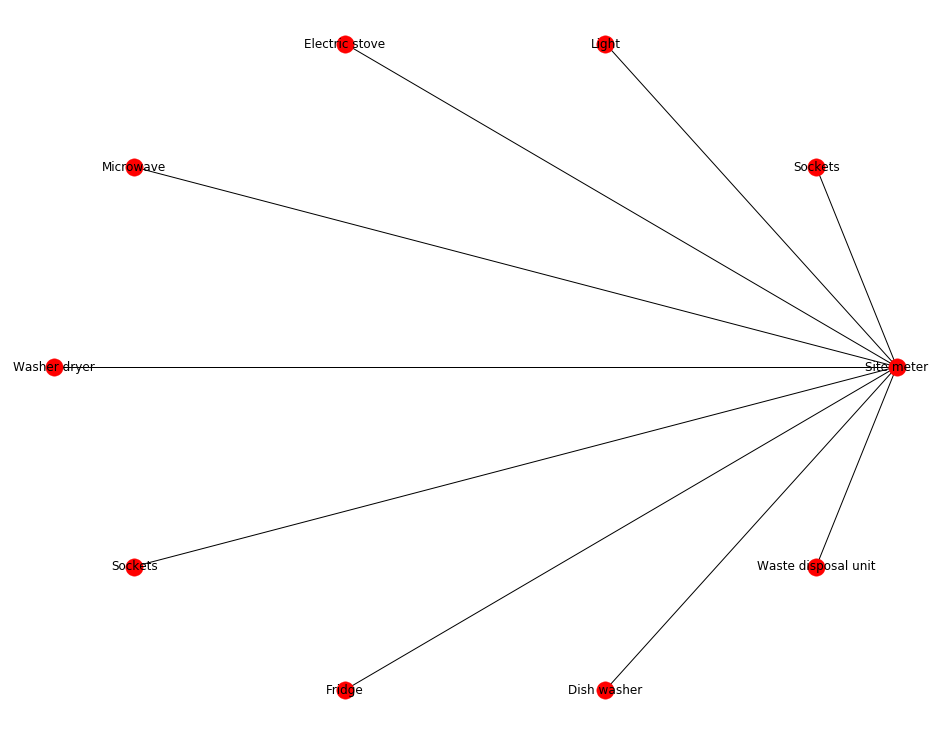

In [22]:
elec.draw_wiring_graph()

Não é muito evidente, mas este diagrama mostra que os medidores (1, 2 - medidores das plantas) estão a montante de todos os outros medidores.

> Residências da base REDD têm apenas dois níveis na sua 'hierarquia' de medidores (correntes principais - mains - e dispositivos individuais - submeters). Se houvessem mais que dois níveis, então seria útil obter apenas os medidores imediatamente a jusante de mains:

In [23]:
elec.meters_directly_downstream_of_mains()

MeterGroup(meters=
  ElecMeter(instance=3, building=2, dataset='REDD', appliances=[Appliance(type='sockets', instance=1)])
  ElecMeter(instance=4, building=2, dataset='REDD', appliances=[Appliance(type='light', instance=1)])
  ElecMeter(instance=5, building=2, dataset='REDD', appliances=[Appliance(type='electric stove', instance=1)])
  ElecMeter(instance=6, building=2, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])
  ElecMeter(instance=7, building=2, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=8, building=2, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])
  ElecMeter(instance=9, building=2, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])
  ElecMeter(instance=10, building=2, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])
  ElecMeter(instance=11, building=2, dataset='REDD', appliances=[Appliance(type='waste disposal unit', instance=1)])
)

### Gráfico de Utilização dos Dispositivos

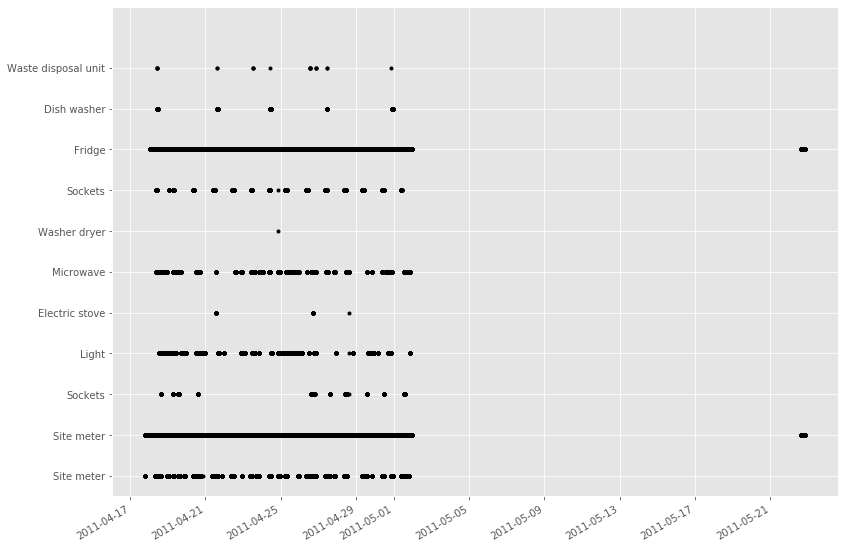

In [24]:
#sns.set_palette("Set3", n_colors=12)
# Set a threshold to remove residual power noise when devices are off
elec.plot_when_on(on_power_threshold = 40)

## Informações e Estatísticas Individuais dos Medidores

A classe `ElecMeter` represente um medidor de eletricidade único. 

Cada `ElecMeter` possui uma lista de objetos `Appliance` (dispositivos) associados.  

`ElecMeter` possui muitos dos mesmos métodos estatísticos do `MeterGroup` tais como `total_energy` e `available_power_ac_types` and `power_series` and `power_series_all_data`.  

Vamos explorar mais algumas funções estatísticas...

In [25]:
fridge_meter = elec['fridge'] # Dados de medição do forno elétrico

### Medidor Imediatamente Superiores

In [26]:
fridge_meter.upstream_meter()

MeterGroup(meters=
  ElecMeter(instance=1, building=2, dataset='REDD', site_meter, appliances=[])
  ElecMeter(instance=2, building=2, dataset='REDD', site_meter, appliances=[])
)

### Metadata da Classe do Medidor

In [27]:
fridge_meter.device

{'model': 'eMonitor',
 'manufacturer': 'Powerhouse Dynamics',
 'manufacturer_url': 'http://powerhousedynamics.com',
 'description': 'Measures circuit-level power demand.  Comes with 24 CTs. This FAQ page suggests the eMonitor measures real (active) power: http://www.energycircle.com/node/14103  although the REDD readme.txt says all channels record apparent power.\n',
 'sample_period': 3,
 'max_sample_period': 50,
 'measurements': [{'physical_quantity': 'power',
   'type': 'active',
   'upper_limit': 5000,
   'lower_limit': 0}],
 'wireless': False}

### Energia Total Consumida (kWh)

In [28]:
fridge_meter.total_energy() # kWh

active    26.634318
dtype: float64

### Outras Informações

Se visualizarmos os dados de energia originais, poderemos observar que há um grande *gap* onde, supostamente, o medidor associado a este dispositivo parou de funcionar (vale ressaltar que, se aumentarmos o zoom, poderemos observar pequenos intervalos com este mesmo comportamento):

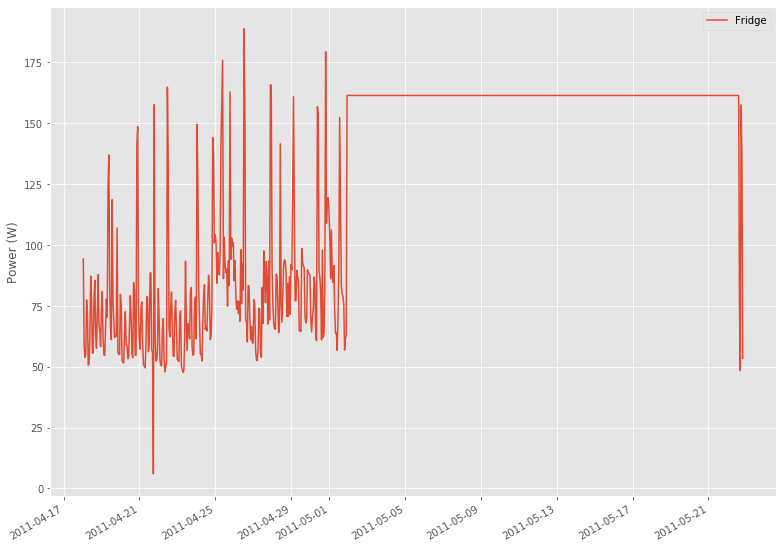

In [29]:
fridge_meter.plot()

Podemos automaticamente identificar 'good sections' (i.e. seções onde cada par de amostras consecutivas é menor que o valor de `max_sample_period` especificado no metadata do dataset):

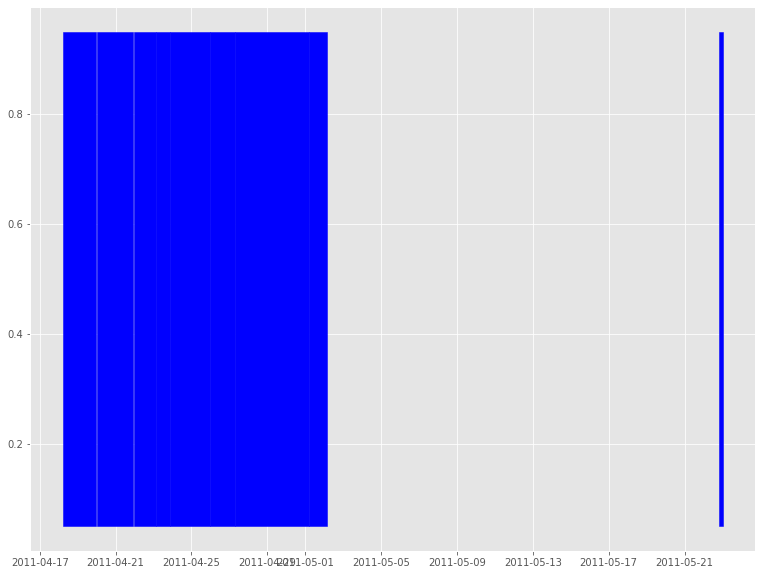

In [30]:
good_sections = fridge_meter.good_sections(full_results=True)
# full_results=False nos dá uma lista dimples de TimeFrames.  
# Mas queremos todos GoodSectionsResults para que seja possível plotar as 'good sections'...
good_sections.plot()

Os blocos mostram onde os dados são 'bons' (good). O *gap* branco é o largo intervalo em branco visto nos dados originais.

É possível também listar as 'good sections':

In [31]:
good_sections.combined()

[TimeFrame(start='2011-04-18 01:31:40-04:00', end='2011-04-19 18:45:06-04:00', empty=False),
 TimeFrame(start='2011-04-19 20:20:05-04:00', end='2011-04-21 17:45:08-04:00', empty=False),
 TimeFrame(start='2011-04-21 19:41:32-04:00', end='2011-04-22 22:46:57-04:00', empty=False),
 TimeFrame(start='2011-04-22 22:48:37-04:00', end='2011-04-23 17:02:57-04:00', empty=False),
 TimeFrame(start='2011-04-23 17:05:04-04:00', end='2011-04-25 19:28:19-04:00', empty=False),
 TimeFrame(start='2011-04-25 19:32:18-04:00', end='2011-04-27 03:17:50-04:00', empty=False),
 TimeFrame(start='2011-04-27 03:21:51-04:00', end='2011-05-01 01:03:53-04:00', empty=False),
 TimeFrame(start='2011-05-01 01:06:19-04:00', end='2011-05-01 23:04:38-04:00', empty=False),
 TimeFrame(start='2011-05-22 15:57:07-04:00', end='2011-05-22 19:59:08-04:00', empty=False)]

## Selecionando Subgrupos de Medidores

Usamos `ElecMeter.select_using_appliances()` para selecionar um novo MeterGroup usando um campo metadata.  
Por exemplo, para pegar todas as máquinas secadores no dataset REDD (considerenado todas residências), fasemos o seguinte:

In [32]:
import nilmtk
nilmtk.global_meter_group.select_using_appliances(type='washer dryer')

MeterGroup(meters=
  ElecMeter(instance=10, building=1, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=20, building=1, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=7, building=2, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=13, building=3, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=14, building=3, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=7, building=4, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=8, building=5, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=9, building=5, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=4, building=6, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1

> Ou selecionamos múltiplos dispositivos pelo tipo:

In [33]:
elec.select_using_appliances(type=['fridge', 'microwave'])

MeterGroup(meters=
  ElecMeter(instance=9, building=2, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])
  ElecMeter(instance=6, building=2, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])
)

> Ou então pela categoria dos dispositivos (por exemplo, os aquecedores):

In [34]:
nilmtk.global_meter_group.select_using_appliances(category='heating')

MeterGroup(meters=
  ElecMeter(instance=13, building=1, dataset='REDD', appliances=[Appliance(type='electric space heater', instance=1)])
  ElecMeter(instance=10, building=3, dataset='REDD', appliances=[Appliance(type='electric furnace', instance=1)])
  ElecMeter(instance=4, building=4, dataset='REDD', appliances=[Appliance(type='electric furnace', instance=1)])
  ElecMeter(instance=6, building=5, dataset='REDD', appliances=[Appliance(type='electric furnace', instance=1)])
  ElecMeter(instance=12, building=5, dataset='REDD', appliances=[Appliance(type='electric space heater', instance=1)])
  ElecMeter(instance=13, building=5, dataset='REDD', appliances=[Appliance(type='electric space heater', instance=1)])
  ElecMeter(instance=12, building=6, dataset='REDD', appliances=[Appliance(type='electric space heater', instance=1)])
)

## Selecionando um Único Dispositivo de um `MeterGroup`

Usamos o marcador `[]` para retornar um único dispositivo (objeto `ElecMeter`) de um `MeterGroup`.

In [35]:
elec['fridge']

ElecMeter(instance=9, building=2, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])

In [36]:
elec.select_using_appliances(type='fridge')

MeterGroup(meters=
  ElecMeter(instance=9, building=2, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])
)

## Gráfico de Consumo de Energia Individual

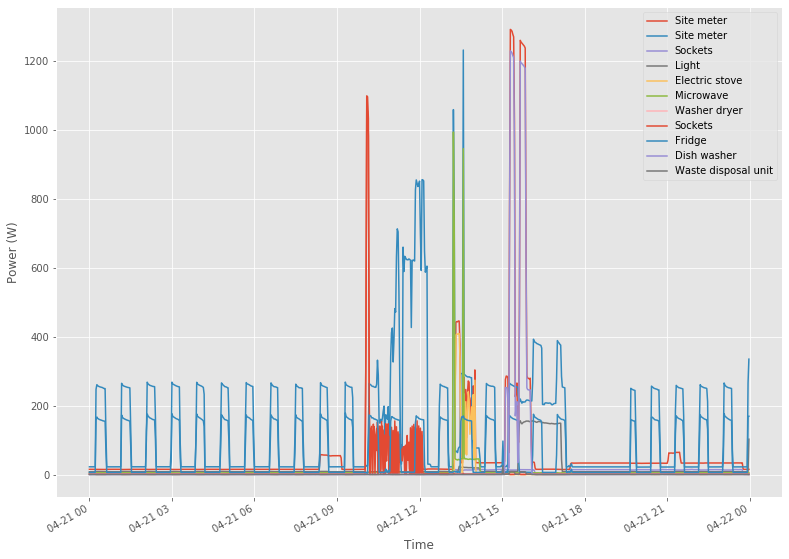

In [37]:
redd.set_window(start='2011-04-21', end='2011-04-22')
elec.plot();
plt.xlabel("Time");

## Gráfico de Autocorrelação

Loading data for meter ElecMeterID(instance=2, building=2, dataset='REDD')     
Done loading data all meters for this chunk.


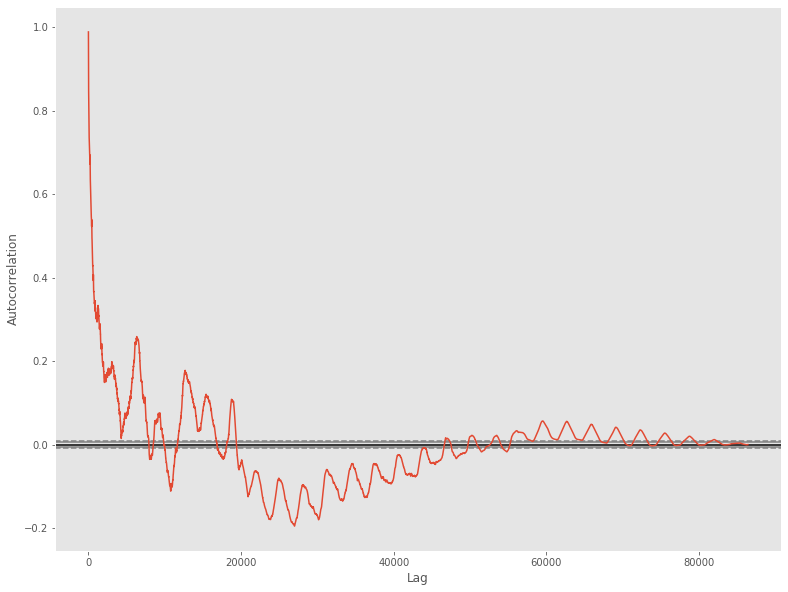

In [38]:
import pandas as pd
from pandas.plotting import autocorrelation_plot

elec.mains().plot_autocorrelation() # Correntes principais

## Consumo de Energia Diário de um Conjunto de Dispositivos

Considerando dispositivos do tipo 'forno elétrico':

In [39]:
import nilmtk

fridges_restricted = nilmtk.global_meter_group.select_using_appliances(type='fridge')
daily_energy = pd.Series([meter.average_energy_per_period(offset_alias='D') 
                          for meter in fridges_restricted.meters])

daily_energy

0    active    1.226223
dtype: float64
1    active    1.529531
dtype: float64
2     active    1.04288
dtype: float64
3    active    0.815836
dtype: float64
4                                  NaN
dtype: object

In [40]:
fridges_restricted.meters

[ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)]),
 ElecMeter(instance=9, building=2, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)]),
 ElecMeter(instance=7, building=3, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)]),
 ElecMeter(instance=18, building=5, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)]),
 ElecMeter(instance=8, building=6, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])]

## Dataframe de Correlação dos Dipositivos

In [41]:
correlation_df = elec.pairwise_correlation()
correlation_df

,"(1, 2, REDD)","(2, 2, REDD)","(3, 2, REDD)","(4, 2, REDD)","(5, 2, REDD)","(6, 2, REDD)","(7, 2, REDD)","(8, 2, REDD)","(9, 2, REDD)","(10, 2, REDD)","(11, 2, REDD)"
"(1, 2, REDD)",1,0.0764376,0.232753,0.225945,0.235584,0.00557294,-0.0692313,0.461766,0.0206536,0.82137,0.220759
"(2, 2, REDD)",0.0764376,1,-0.17845,0.185049,0.00014574,0.419828,0.063051,0.0510762,0.603159,0.0658018,0.0583235
"(3, 2, REDD)",0.232753,-0.17845,1,0.00687639,0.154552,0.0288796,-0.00420936,-0.0137133,-0.128921,0.1926,0.064297
"(4, 2, REDD)",0.225945,0.185049,0.00687639,1,-0.00778073,-0.0016597,-0.144637,-0.0357135,0.0131278,0.298358,0.0762418
"(5, 2, REDD)",0.235584,0.00014574,0.154552,-0.00778073,1,0.0533058,0.0092044,-0.00838405,0.00116777,-0.021566,-0.00679553
"(6, 2, REDD)",0.00557294,0.419828,0.0288796,-0.0016597,0.0533058,1,0.350702,-0.00580752,0.013842,-0.00852056,-0.00285931
"(7, 2, REDD)",-0.0692313,0.063051,-0.00420936,-0.144637,0.0092044,0.350702,1,-0.0744863,0.0275171,-0.0394351,-0.00900302
"(8, 2, REDD)",0.461766,0.0510762,-0.0137133,-0.0357135,-0.00838405,-0.00580752,-0.0744863,1,-0.00545451,-0.0166536,-0.00530469
"(9, 2, REDD)",0.0206536,0.603159,-0.128921,0.0131278,0.00116777,0.013842,0.0275171,-0.00545451,1,0.0285216,0.00105204
"(10, 2, REDD)",0.82137,0.0658018,0.1926,0.298358,-0.021566,-0.00852056,-0.0394351,-0.0166536,0.0285216,1,0.268956


# Machine Learning

## Pré-processamento dos dados para o classificador

In [40]:
redd.buildings[1].elec

MeterGroup(meters=
  ElecMeter(instance=1, building=1, dataset='REDD', site_meter, appliances=[])
  ElecMeter(instance=2, building=1, dataset='REDD', site_meter, appliances=[])
  ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])
  ElecMeter(instance=6, building=1, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])
  ElecMeter(instance=7, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=1)])
  ElecMeter(instance=8, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])
  ElecMeter(instance=9, building=1, dataset='REDD', appliances=[Appliance(type='light', instance=1)])
  ElecMeter(instance=11, building=1, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])
  ElecMeter(instance=12, building=1, dataset='REDD', appliances=[Appliance(type='unknown', instance=1)])
  ElecMeter(instance=13, building=1, dataset='REDD', appliances=[Appliance(type='electric 

Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.
Meter 20 is in a nested meter group. Retrieving just the ElecMeter.


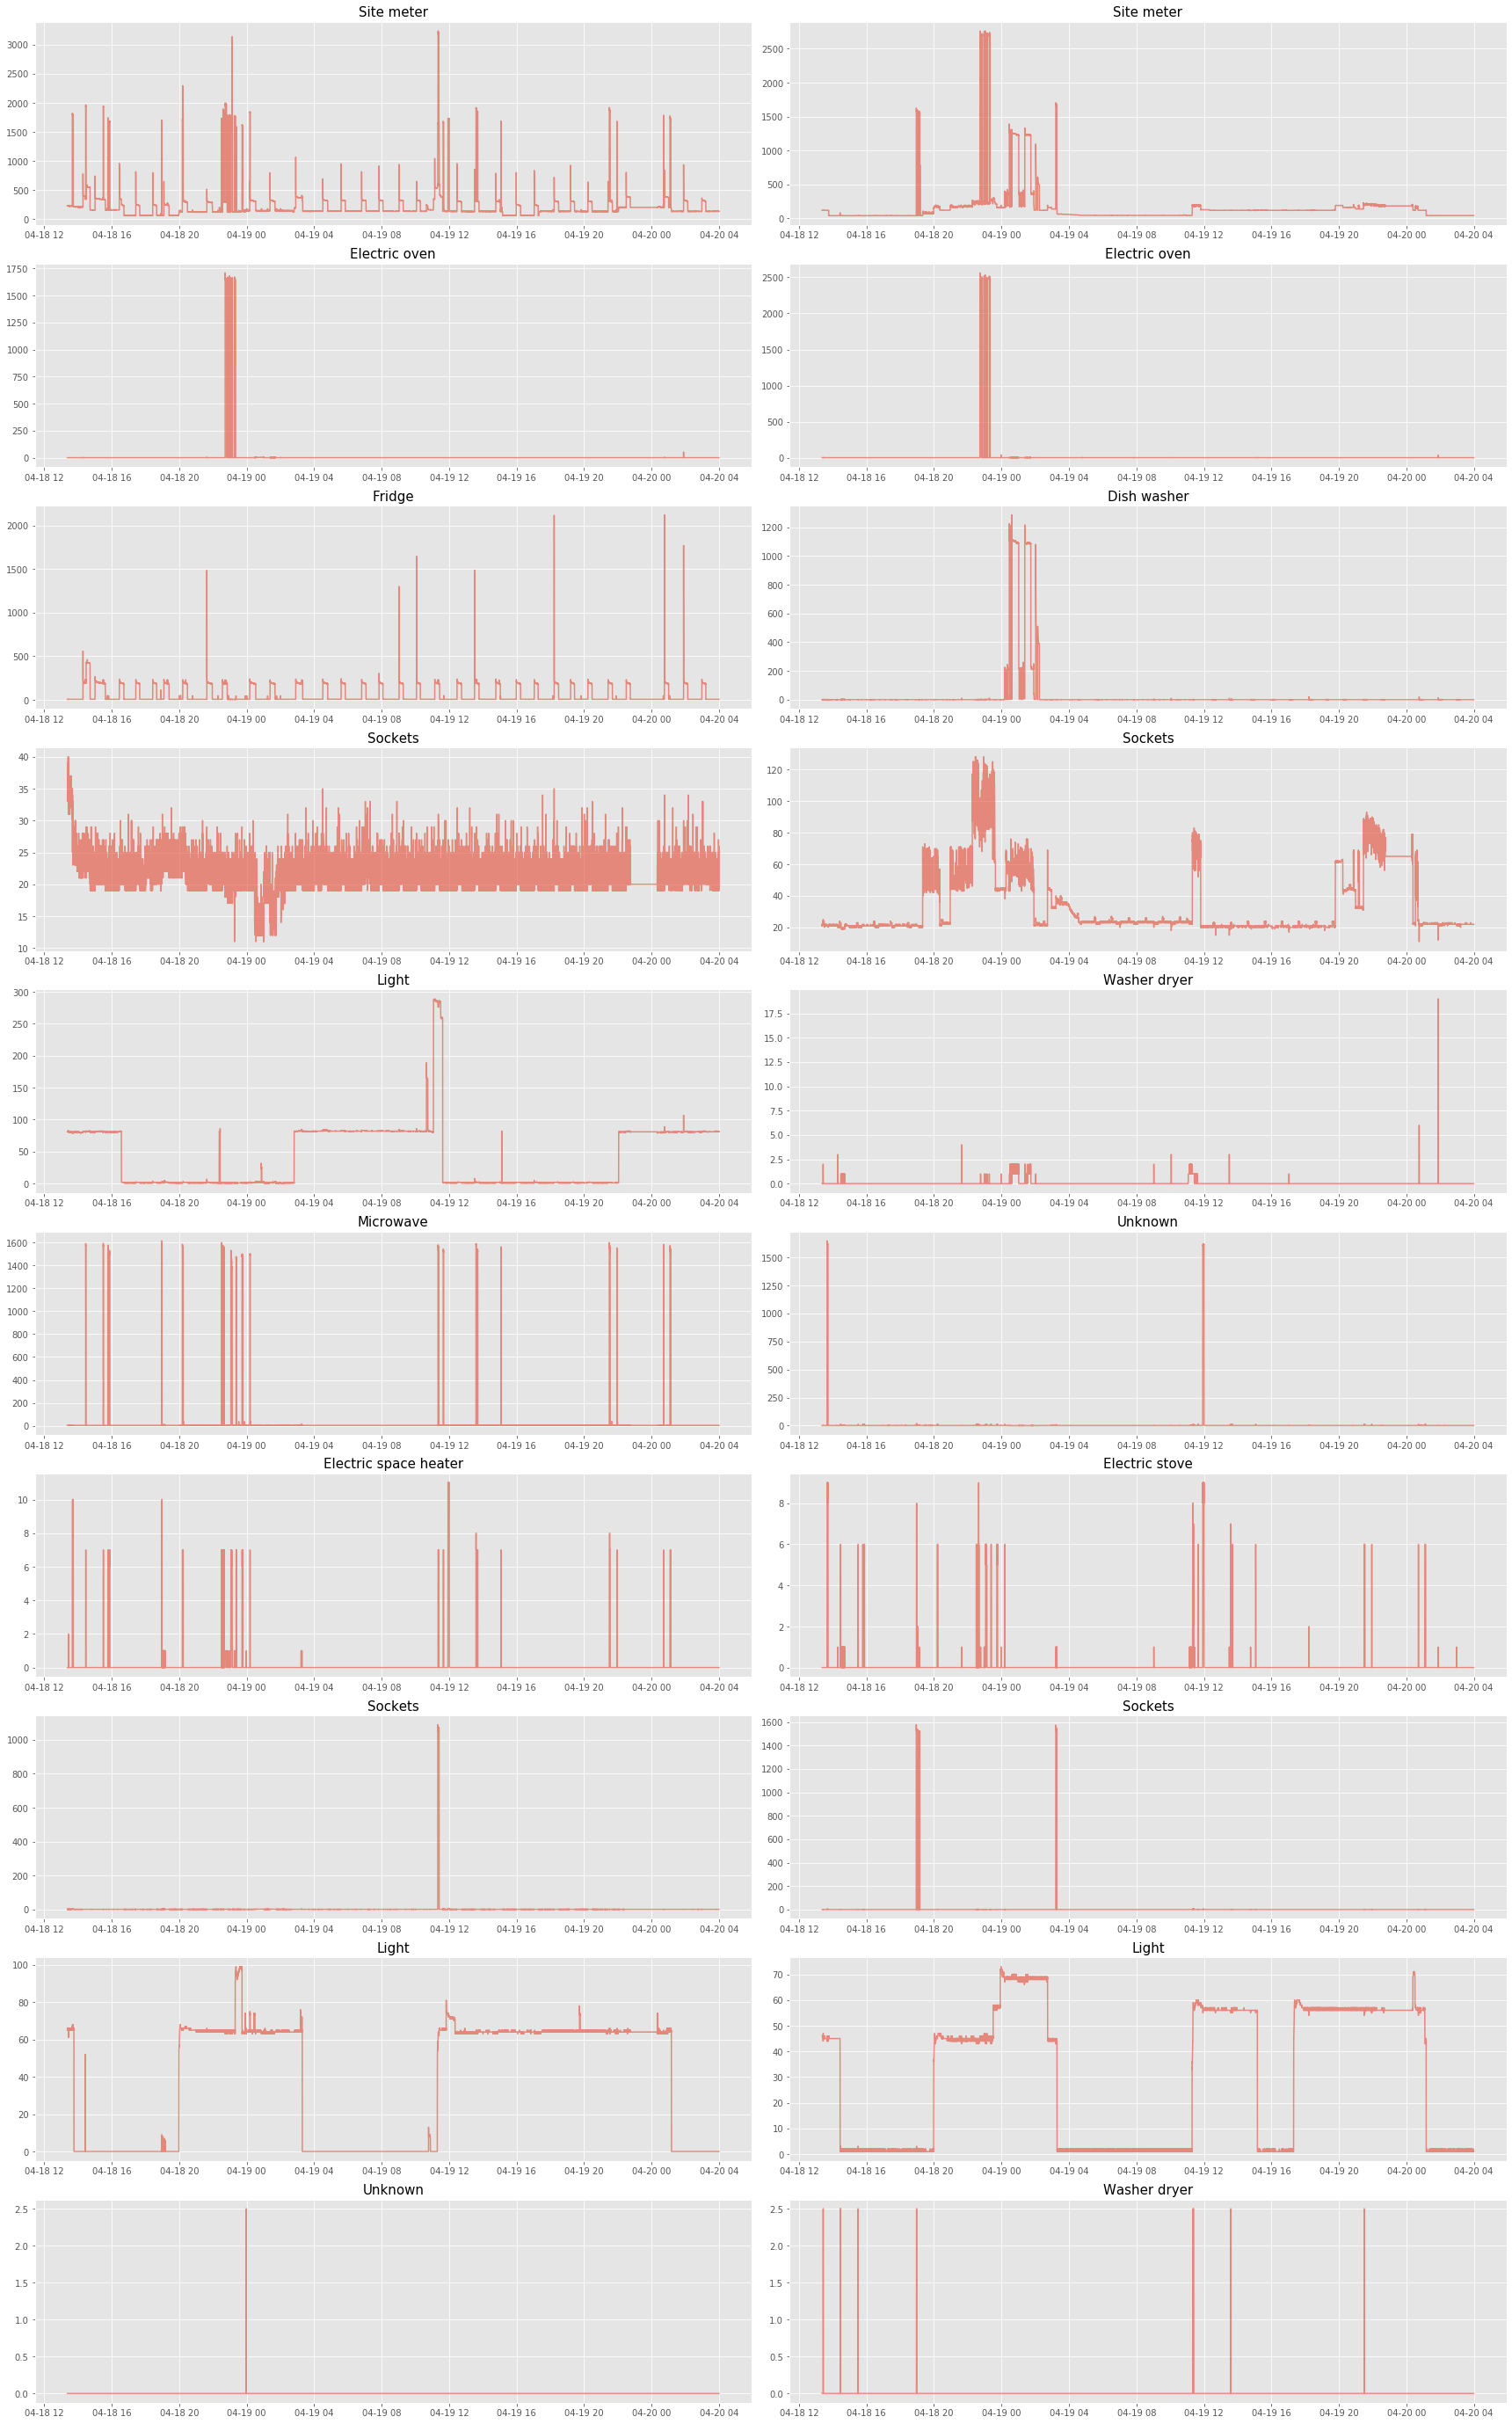

In [41]:
redd.set_window(start='2011-04-18', end='2011-04-20')

num_apps = 20
fig, axes = plt.subplots((num_apps+1)//2,2, figsize=(24, num_apps*2) )
for i in range(num_apps):
    e = redd.buildings[1].elec[i+1]
    axes.flat[i].plot(e.power_series_all_data(sample_period=3), alpha = 0.6)
    axes.flat[i].set_title(e.label(), fontsize = '15')
plt.suptitle('', fontsize = '30')
fig.tight_layout()
fig.subplots_adjust(top=0.95)

In [42]:
#plt.plot(row[max_observations:(max_observations*2)-1])

### Split de Blocos de Medições (1 bloco = 5 minutos)

In [43]:
# Intervalos de geracao dos dados
from datetime import datetime, timedelta


In [44]:
# Configurações da amostragem

# Informações do CS446 Project : Electric Load Identification using Machine Learning (REDD)
set_sampling_rate = 3 
start = datetime(2011, 4, 16, 5, 11, 27)
end = datetime(2011, 5, 31, 0, 19, 54)
time_interval_minutes = 5 # Split de amostra


# ... 6 seconds - Imaging Time Series  (UK-DALE)

In [45]:

def datetime_range(start, end, delta):
    current = start
    while current < end:
        yield current
        current += delta

dts = [dt.strftime('%Y-%m-%d %H:%M:%S') 
           for dt in 
               datetime_range(start, 
                              end, 
                              timedelta(minutes=time_interval_minutes))]
#dts

In [46]:
# Validando intervalos...
for idx in range(1, len(dts)):
    print('de', dts[idx-1], ' a ', dts[idx])

de 2011-04-16 05:11:27  a  2011-04-16 05:16:27
de 2011-04-16 05:16:27  a  2011-04-16 05:21:27
de 2011-04-16 05:21:27  a  2011-04-16 05:26:27
de 2011-04-16 05:26:27  a  2011-04-16 05:31:27
de 2011-04-16 05:31:27  a  2011-04-16 05:36:27
de 2011-04-16 05:36:27  a  2011-04-16 05:41:27
de 2011-04-16 05:41:27  a  2011-04-16 05:46:27
de 2011-04-16 05:46:27  a  2011-04-16 05:51:27
de 2011-04-16 05:51:27  a  2011-04-16 05:56:27
de 2011-04-16 05:56:27  a  2011-04-16 06:01:27
de 2011-04-16 06:01:27  a  2011-04-16 06:06:27
de 2011-04-16 06:06:27  a  2011-04-16 06:11:27
de 2011-04-16 06:11:27  a  2011-04-16 06:16:27
de 2011-04-16 06:16:27  a  2011-04-16 06:21:27
de 2011-04-16 06:21:27  a  2011-04-16 06:26:27
de 2011-04-16 06:26:27  a  2011-04-16 06:31:27
de 2011-04-16 06:31:27  a  2011-04-16 06:36:27
de 2011-04-16 06:36:27  a  2011-04-16 06:41:27
de 2011-04-16 06:41:27  a  2011-04-16 06:46:27
de 2011-04-16 06:46:27  a  2011-04-16 06:51:27
de 2011-04-16 06:51:27  a  2011-04-16 06:56:27
de 2011-04-16

de 2011-04-17 14:36:27  a  2011-04-17 14:41:27
de 2011-04-17 14:41:27  a  2011-04-17 14:46:27
de 2011-04-17 14:46:27  a  2011-04-17 14:51:27
de 2011-04-17 14:51:27  a  2011-04-17 14:56:27
de 2011-04-17 14:56:27  a  2011-04-17 15:01:27
de 2011-04-17 15:01:27  a  2011-04-17 15:06:27
de 2011-04-17 15:06:27  a  2011-04-17 15:11:27
de 2011-04-17 15:11:27  a  2011-04-17 15:16:27
de 2011-04-17 15:16:27  a  2011-04-17 15:21:27
de 2011-04-17 15:21:27  a  2011-04-17 15:26:27
de 2011-04-17 15:26:27  a  2011-04-17 15:31:27
de 2011-04-17 15:31:27  a  2011-04-17 15:36:27
de 2011-04-17 15:36:27  a  2011-04-17 15:41:27
de 2011-04-17 15:41:27  a  2011-04-17 15:46:27
de 2011-04-17 15:46:27  a  2011-04-17 15:51:27
de 2011-04-17 15:51:27  a  2011-04-17 15:56:27
de 2011-04-17 15:56:27  a  2011-04-17 16:01:27
de 2011-04-17 16:01:27  a  2011-04-17 16:06:27
de 2011-04-17 16:06:27  a  2011-04-17 16:11:27
de 2011-04-17 16:11:27  a  2011-04-17 16:16:27
de 2011-04-17 16:16:27  a  2011-04-17 16:21:27
de 2011-04-17

de 2011-04-18 23:21:27  a  2011-04-18 23:26:27
de 2011-04-18 23:26:27  a  2011-04-18 23:31:27
de 2011-04-18 23:31:27  a  2011-04-18 23:36:27
de 2011-04-18 23:36:27  a  2011-04-18 23:41:27
de 2011-04-18 23:41:27  a  2011-04-18 23:46:27
de 2011-04-18 23:46:27  a  2011-04-18 23:51:27
de 2011-04-18 23:51:27  a  2011-04-18 23:56:27
de 2011-04-18 23:56:27  a  2011-04-19 00:01:27
de 2011-04-19 00:01:27  a  2011-04-19 00:06:27
de 2011-04-19 00:06:27  a  2011-04-19 00:11:27
de 2011-04-19 00:11:27  a  2011-04-19 00:16:27
de 2011-04-19 00:16:27  a  2011-04-19 00:21:27
de 2011-04-19 00:21:27  a  2011-04-19 00:26:27
de 2011-04-19 00:26:27  a  2011-04-19 00:31:27
de 2011-04-19 00:31:27  a  2011-04-19 00:36:27
de 2011-04-19 00:36:27  a  2011-04-19 00:41:27
de 2011-04-19 00:41:27  a  2011-04-19 00:46:27
de 2011-04-19 00:46:27  a  2011-04-19 00:51:27
de 2011-04-19 00:51:27  a  2011-04-19 00:56:27
de 2011-04-19 00:56:27  a  2011-04-19 01:01:27
de 2011-04-19 01:01:27  a  2011-04-19 01:06:27
de 2011-04-19

de 2011-04-20 05:46:27  a  2011-04-20 05:51:27
de 2011-04-20 05:51:27  a  2011-04-20 05:56:27
de 2011-04-20 05:56:27  a  2011-04-20 06:01:27
de 2011-04-20 06:01:27  a  2011-04-20 06:06:27
de 2011-04-20 06:06:27  a  2011-04-20 06:11:27
de 2011-04-20 06:11:27  a  2011-04-20 06:16:27
de 2011-04-20 06:16:27  a  2011-04-20 06:21:27
de 2011-04-20 06:21:27  a  2011-04-20 06:26:27
de 2011-04-20 06:26:27  a  2011-04-20 06:31:27
de 2011-04-20 06:31:27  a  2011-04-20 06:36:27
de 2011-04-20 06:36:27  a  2011-04-20 06:41:27
de 2011-04-20 06:41:27  a  2011-04-20 06:46:27
de 2011-04-20 06:46:27  a  2011-04-20 06:51:27
de 2011-04-20 06:51:27  a  2011-04-20 06:56:27
de 2011-04-20 06:56:27  a  2011-04-20 07:01:27
de 2011-04-20 07:01:27  a  2011-04-20 07:06:27
de 2011-04-20 07:06:27  a  2011-04-20 07:11:27
de 2011-04-20 07:11:27  a  2011-04-20 07:16:27
de 2011-04-20 07:16:27  a  2011-04-20 07:21:27
de 2011-04-20 07:21:27  a  2011-04-20 07:26:27
de 2011-04-20 07:26:27  a  2011-04-20 07:31:27
de 2011-04-20

de 2011-04-21 15:06:27  a  2011-04-21 15:11:27
de 2011-04-21 15:11:27  a  2011-04-21 15:16:27
de 2011-04-21 15:16:27  a  2011-04-21 15:21:27
de 2011-04-21 15:21:27  a  2011-04-21 15:26:27
de 2011-04-21 15:26:27  a  2011-04-21 15:31:27
de 2011-04-21 15:31:27  a  2011-04-21 15:36:27
de 2011-04-21 15:36:27  a  2011-04-21 15:41:27
de 2011-04-21 15:41:27  a  2011-04-21 15:46:27
de 2011-04-21 15:46:27  a  2011-04-21 15:51:27
de 2011-04-21 15:51:27  a  2011-04-21 15:56:27
de 2011-04-21 15:56:27  a  2011-04-21 16:01:27
de 2011-04-21 16:01:27  a  2011-04-21 16:06:27
de 2011-04-21 16:06:27  a  2011-04-21 16:11:27
de 2011-04-21 16:11:27  a  2011-04-21 16:16:27
de 2011-04-21 16:16:27  a  2011-04-21 16:21:27
de 2011-04-21 16:21:27  a  2011-04-21 16:26:27
de 2011-04-21 16:26:27  a  2011-04-21 16:31:27
de 2011-04-21 16:31:27  a  2011-04-21 16:36:27
de 2011-04-21 16:36:27  a  2011-04-21 16:41:27
de 2011-04-21 16:41:27  a  2011-04-21 16:46:27
de 2011-04-21 16:46:27  a  2011-04-21 16:51:27
de 2011-04-21

de 2011-04-22 23:41:27  a  2011-04-22 23:46:27
de 2011-04-22 23:46:27  a  2011-04-22 23:51:27
de 2011-04-22 23:51:27  a  2011-04-22 23:56:27
de 2011-04-22 23:56:27  a  2011-04-23 00:01:27
de 2011-04-23 00:01:27  a  2011-04-23 00:06:27
de 2011-04-23 00:06:27  a  2011-04-23 00:11:27
de 2011-04-23 00:11:27  a  2011-04-23 00:16:27
de 2011-04-23 00:16:27  a  2011-04-23 00:21:27
de 2011-04-23 00:21:27  a  2011-04-23 00:26:27
de 2011-04-23 00:26:27  a  2011-04-23 00:31:27
de 2011-04-23 00:31:27  a  2011-04-23 00:36:27
de 2011-04-23 00:36:27  a  2011-04-23 00:41:27
de 2011-04-23 00:41:27  a  2011-04-23 00:46:27
de 2011-04-23 00:46:27  a  2011-04-23 00:51:27
de 2011-04-23 00:51:27  a  2011-04-23 00:56:27
de 2011-04-23 00:56:27  a  2011-04-23 01:01:27
de 2011-04-23 01:01:27  a  2011-04-23 01:06:27
de 2011-04-23 01:06:27  a  2011-04-23 01:11:27
de 2011-04-23 01:11:27  a  2011-04-23 01:16:27
de 2011-04-23 01:16:27  a  2011-04-23 01:21:27
de 2011-04-23 01:21:27  a  2011-04-23 01:26:27
de 2011-04-23

de 2011-04-24 09:06:27  a  2011-04-24 09:11:27
de 2011-04-24 09:11:27  a  2011-04-24 09:16:27
de 2011-04-24 09:16:27  a  2011-04-24 09:21:27
de 2011-04-24 09:21:27  a  2011-04-24 09:26:27
de 2011-04-24 09:26:27  a  2011-04-24 09:31:27
de 2011-04-24 09:31:27  a  2011-04-24 09:36:27
de 2011-04-24 09:36:27  a  2011-04-24 09:41:27
de 2011-04-24 09:41:27  a  2011-04-24 09:46:27
de 2011-04-24 09:46:27  a  2011-04-24 09:51:27
de 2011-04-24 09:51:27  a  2011-04-24 09:56:27
de 2011-04-24 09:56:27  a  2011-04-24 10:01:27
de 2011-04-24 10:01:27  a  2011-04-24 10:06:27
de 2011-04-24 10:06:27  a  2011-04-24 10:11:27
de 2011-04-24 10:11:27  a  2011-04-24 10:16:27
de 2011-04-24 10:16:27  a  2011-04-24 10:21:27
de 2011-04-24 10:21:27  a  2011-04-24 10:26:27
de 2011-04-24 10:26:27  a  2011-04-24 10:31:27
de 2011-04-24 10:31:27  a  2011-04-24 10:36:27
de 2011-04-24 10:36:27  a  2011-04-24 10:41:27
de 2011-04-24 10:41:27  a  2011-04-24 10:46:27
de 2011-04-24 10:46:27  a  2011-04-24 10:51:27
de 2011-04-24

de 2011-04-25 18:21:27  a  2011-04-25 18:26:27
de 2011-04-25 18:26:27  a  2011-04-25 18:31:27
de 2011-04-25 18:31:27  a  2011-04-25 18:36:27
de 2011-04-25 18:36:27  a  2011-04-25 18:41:27
de 2011-04-25 18:41:27  a  2011-04-25 18:46:27
de 2011-04-25 18:46:27  a  2011-04-25 18:51:27
de 2011-04-25 18:51:27  a  2011-04-25 18:56:27
de 2011-04-25 18:56:27  a  2011-04-25 19:01:27
de 2011-04-25 19:01:27  a  2011-04-25 19:06:27
de 2011-04-25 19:06:27  a  2011-04-25 19:11:27
de 2011-04-25 19:11:27  a  2011-04-25 19:16:27
de 2011-04-25 19:16:27  a  2011-04-25 19:21:27
de 2011-04-25 19:21:27  a  2011-04-25 19:26:27
de 2011-04-25 19:26:27  a  2011-04-25 19:31:27
de 2011-04-25 19:31:27  a  2011-04-25 19:36:27
de 2011-04-25 19:36:27  a  2011-04-25 19:41:27
de 2011-04-25 19:41:27  a  2011-04-25 19:46:27
de 2011-04-25 19:46:27  a  2011-04-25 19:51:27
de 2011-04-25 19:51:27  a  2011-04-25 19:56:27
de 2011-04-25 19:56:27  a  2011-04-25 20:01:27
de 2011-04-25 20:01:27  a  2011-04-25 20:06:27
de 2011-04-25

de 2011-04-27 03:16:27  a  2011-04-27 03:21:27
de 2011-04-27 03:21:27  a  2011-04-27 03:26:27
de 2011-04-27 03:26:27  a  2011-04-27 03:31:27
de 2011-04-27 03:31:27  a  2011-04-27 03:36:27
de 2011-04-27 03:36:27  a  2011-04-27 03:41:27
de 2011-04-27 03:41:27  a  2011-04-27 03:46:27
de 2011-04-27 03:46:27  a  2011-04-27 03:51:27
de 2011-04-27 03:51:27  a  2011-04-27 03:56:27
de 2011-04-27 03:56:27  a  2011-04-27 04:01:27
de 2011-04-27 04:01:27  a  2011-04-27 04:06:27
de 2011-04-27 04:06:27  a  2011-04-27 04:11:27
de 2011-04-27 04:11:27  a  2011-04-27 04:16:27
de 2011-04-27 04:16:27  a  2011-04-27 04:21:27
de 2011-04-27 04:21:27  a  2011-04-27 04:26:27
de 2011-04-27 04:26:27  a  2011-04-27 04:31:27
de 2011-04-27 04:31:27  a  2011-04-27 04:36:27
de 2011-04-27 04:36:27  a  2011-04-27 04:41:27
de 2011-04-27 04:41:27  a  2011-04-27 04:46:27
de 2011-04-27 04:46:27  a  2011-04-27 04:51:27
de 2011-04-27 04:51:27  a  2011-04-27 04:56:27
de 2011-04-27 04:56:27  a  2011-04-27 05:01:27
de 2011-04-27

de 2011-04-28 13:11:27  a  2011-04-28 13:16:27
de 2011-04-28 13:16:27  a  2011-04-28 13:21:27
de 2011-04-28 13:21:27  a  2011-04-28 13:26:27
de 2011-04-28 13:26:27  a  2011-04-28 13:31:27
de 2011-04-28 13:31:27  a  2011-04-28 13:36:27
de 2011-04-28 13:36:27  a  2011-04-28 13:41:27
de 2011-04-28 13:41:27  a  2011-04-28 13:46:27
de 2011-04-28 13:46:27  a  2011-04-28 13:51:27
de 2011-04-28 13:51:27  a  2011-04-28 13:56:27
de 2011-04-28 13:56:27  a  2011-04-28 14:01:27
de 2011-04-28 14:01:27  a  2011-04-28 14:06:27
de 2011-04-28 14:06:27  a  2011-04-28 14:11:27
de 2011-04-28 14:11:27  a  2011-04-28 14:16:27
de 2011-04-28 14:16:27  a  2011-04-28 14:21:27
de 2011-04-28 14:21:27  a  2011-04-28 14:26:27
de 2011-04-28 14:26:27  a  2011-04-28 14:31:27
de 2011-04-28 14:31:27  a  2011-04-28 14:36:27
de 2011-04-28 14:36:27  a  2011-04-28 14:41:27
de 2011-04-28 14:41:27  a  2011-04-28 14:46:27
de 2011-04-28 14:46:27  a  2011-04-28 14:51:27
de 2011-04-28 14:51:27  a  2011-04-28 14:56:27
de 2011-04-28

de 2011-04-29 21:31:27  a  2011-04-29 21:36:27
de 2011-04-29 21:36:27  a  2011-04-29 21:41:27
de 2011-04-29 21:41:27  a  2011-04-29 21:46:27
de 2011-04-29 21:46:27  a  2011-04-29 21:51:27
de 2011-04-29 21:51:27  a  2011-04-29 21:56:27
de 2011-04-29 21:56:27  a  2011-04-29 22:01:27
de 2011-04-29 22:01:27  a  2011-04-29 22:06:27
de 2011-04-29 22:06:27  a  2011-04-29 22:11:27
de 2011-04-29 22:11:27  a  2011-04-29 22:16:27
de 2011-04-29 22:16:27  a  2011-04-29 22:21:27
de 2011-04-29 22:21:27  a  2011-04-29 22:26:27
de 2011-04-29 22:26:27  a  2011-04-29 22:31:27
de 2011-04-29 22:31:27  a  2011-04-29 22:36:27
de 2011-04-29 22:36:27  a  2011-04-29 22:41:27
de 2011-04-29 22:41:27  a  2011-04-29 22:46:27
de 2011-04-29 22:46:27  a  2011-04-29 22:51:27
de 2011-04-29 22:51:27  a  2011-04-29 22:56:27
de 2011-04-29 22:56:27  a  2011-04-29 23:01:27
de 2011-04-29 23:01:27  a  2011-04-29 23:06:27
de 2011-04-29 23:06:27  a  2011-04-29 23:11:27
de 2011-04-29 23:11:27  a  2011-04-29 23:16:27
de 2011-04-29

de 2011-05-01 05:46:27  a  2011-05-01 05:51:27
de 2011-05-01 05:51:27  a  2011-05-01 05:56:27
de 2011-05-01 05:56:27  a  2011-05-01 06:01:27
de 2011-05-01 06:01:27  a  2011-05-01 06:06:27
de 2011-05-01 06:06:27  a  2011-05-01 06:11:27
de 2011-05-01 06:11:27  a  2011-05-01 06:16:27
de 2011-05-01 06:16:27  a  2011-05-01 06:21:27
de 2011-05-01 06:21:27  a  2011-05-01 06:26:27
de 2011-05-01 06:26:27  a  2011-05-01 06:31:27
de 2011-05-01 06:31:27  a  2011-05-01 06:36:27
de 2011-05-01 06:36:27  a  2011-05-01 06:41:27
de 2011-05-01 06:41:27  a  2011-05-01 06:46:27
de 2011-05-01 06:46:27  a  2011-05-01 06:51:27
de 2011-05-01 06:51:27  a  2011-05-01 06:56:27
de 2011-05-01 06:56:27  a  2011-05-01 07:01:27
de 2011-05-01 07:01:27  a  2011-05-01 07:06:27
de 2011-05-01 07:06:27  a  2011-05-01 07:11:27
de 2011-05-01 07:11:27  a  2011-05-01 07:16:27
de 2011-05-01 07:16:27  a  2011-05-01 07:21:27
de 2011-05-01 07:21:27  a  2011-05-01 07:26:27
de 2011-05-01 07:26:27  a  2011-05-01 07:31:27
de 2011-05-01

de 2011-05-02 14:36:27  a  2011-05-02 14:41:27
de 2011-05-02 14:41:27  a  2011-05-02 14:46:27
de 2011-05-02 14:46:27  a  2011-05-02 14:51:27
de 2011-05-02 14:51:27  a  2011-05-02 14:56:27
de 2011-05-02 14:56:27  a  2011-05-02 15:01:27
de 2011-05-02 15:01:27  a  2011-05-02 15:06:27
de 2011-05-02 15:06:27  a  2011-05-02 15:11:27
de 2011-05-02 15:11:27  a  2011-05-02 15:16:27
de 2011-05-02 15:16:27  a  2011-05-02 15:21:27
de 2011-05-02 15:21:27  a  2011-05-02 15:26:27
de 2011-05-02 15:26:27  a  2011-05-02 15:31:27
de 2011-05-02 15:31:27  a  2011-05-02 15:36:27
de 2011-05-02 15:36:27  a  2011-05-02 15:41:27
de 2011-05-02 15:41:27  a  2011-05-02 15:46:27
de 2011-05-02 15:46:27  a  2011-05-02 15:51:27
de 2011-05-02 15:51:27  a  2011-05-02 15:56:27
de 2011-05-02 15:56:27  a  2011-05-02 16:01:27
de 2011-05-02 16:01:27  a  2011-05-02 16:06:27
de 2011-05-02 16:06:27  a  2011-05-02 16:11:27
de 2011-05-02 16:11:27  a  2011-05-02 16:16:27
de 2011-05-02 16:16:27  a  2011-05-02 16:21:27
de 2011-05-02

de 2011-05-03 22:41:27  a  2011-05-03 22:46:27
de 2011-05-03 22:46:27  a  2011-05-03 22:51:27
de 2011-05-03 22:51:27  a  2011-05-03 22:56:27
de 2011-05-03 22:56:27  a  2011-05-03 23:01:27
de 2011-05-03 23:01:27  a  2011-05-03 23:06:27
de 2011-05-03 23:06:27  a  2011-05-03 23:11:27
de 2011-05-03 23:11:27  a  2011-05-03 23:16:27
de 2011-05-03 23:16:27  a  2011-05-03 23:21:27
de 2011-05-03 23:21:27  a  2011-05-03 23:26:27
de 2011-05-03 23:26:27  a  2011-05-03 23:31:27
de 2011-05-03 23:31:27  a  2011-05-03 23:36:27
de 2011-05-03 23:36:27  a  2011-05-03 23:41:27
de 2011-05-03 23:41:27  a  2011-05-03 23:46:27
de 2011-05-03 23:46:27  a  2011-05-03 23:51:27
de 2011-05-03 23:51:27  a  2011-05-03 23:56:27
de 2011-05-03 23:56:27  a  2011-05-04 00:01:27
de 2011-05-04 00:01:27  a  2011-05-04 00:06:27
de 2011-05-04 00:06:27  a  2011-05-04 00:11:27
de 2011-05-04 00:11:27  a  2011-05-04 00:16:27
de 2011-05-04 00:16:27  a  2011-05-04 00:21:27
de 2011-05-04 00:21:27  a  2011-05-04 00:26:27
de 2011-05-04

de 2011-05-05 07:41:27  a  2011-05-05 07:46:27
de 2011-05-05 07:46:27  a  2011-05-05 07:51:27
de 2011-05-05 07:51:27  a  2011-05-05 07:56:27
de 2011-05-05 07:56:27  a  2011-05-05 08:01:27
de 2011-05-05 08:01:27  a  2011-05-05 08:06:27
de 2011-05-05 08:06:27  a  2011-05-05 08:11:27
de 2011-05-05 08:11:27  a  2011-05-05 08:16:27
de 2011-05-05 08:16:27  a  2011-05-05 08:21:27
de 2011-05-05 08:21:27  a  2011-05-05 08:26:27
de 2011-05-05 08:26:27  a  2011-05-05 08:31:27
de 2011-05-05 08:31:27  a  2011-05-05 08:36:27
de 2011-05-05 08:36:27  a  2011-05-05 08:41:27
de 2011-05-05 08:41:27  a  2011-05-05 08:46:27
de 2011-05-05 08:46:27  a  2011-05-05 08:51:27
de 2011-05-05 08:51:27  a  2011-05-05 08:56:27
de 2011-05-05 08:56:27  a  2011-05-05 09:01:27
de 2011-05-05 09:01:27  a  2011-05-05 09:06:27
de 2011-05-05 09:06:27  a  2011-05-05 09:11:27
de 2011-05-05 09:11:27  a  2011-05-05 09:16:27
de 2011-05-05 09:16:27  a  2011-05-05 09:21:27
de 2011-05-05 09:21:27  a  2011-05-05 09:26:27
de 2011-05-05

de 2011-05-06 16:51:27  a  2011-05-06 16:56:27
de 2011-05-06 16:56:27  a  2011-05-06 17:01:27
de 2011-05-06 17:01:27  a  2011-05-06 17:06:27
de 2011-05-06 17:06:27  a  2011-05-06 17:11:27
de 2011-05-06 17:11:27  a  2011-05-06 17:16:27
de 2011-05-06 17:16:27  a  2011-05-06 17:21:27
de 2011-05-06 17:21:27  a  2011-05-06 17:26:27
de 2011-05-06 17:26:27  a  2011-05-06 17:31:27
de 2011-05-06 17:31:27  a  2011-05-06 17:36:27
de 2011-05-06 17:36:27  a  2011-05-06 17:41:27
de 2011-05-06 17:41:27  a  2011-05-06 17:46:27
de 2011-05-06 17:46:27  a  2011-05-06 17:51:27
de 2011-05-06 17:51:27  a  2011-05-06 17:56:27
de 2011-05-06 17:56:27  a  2011-05-06 18:01:27
de 2011-05-06 18:01:27  a  2011-05-06 18:06:27
de 2011-05-06 18:06:27  a  2011-05-06 18:11:27
de 2011-05-06 18:11:27  a  2011-05-06 18:16:27
de 2011-05-06 18:16:27  a  2011-05-06 18:21:27
de 2011-05-06 18:21:27  a  2011-05-06 18:26:27
de 2011-05-06 18:26:27  a  2011-05-06 18:31:27
de 2011-05-06 18:31:27  a  2011-05-06 18:36:27
de 2011-05-06

de 2011-05-08 02:11:27  a  2011-05-08 02:16:27
de 2011-05-08 02:16:27  a  2011-05-08 02:21:27
de 2011-05-08 02:21:27  a  2011-05-08 02:26:27
de 2011-05-08 02:26:27  a  2011-05-08 02:31:27
de 2011-05-08 02:31:27  a  2011-05-08 02:36:27
de 2011-05-08 02:36:27  a  2011-05-08 02:41:27
de 2011-05-08 02:41:27  a  2011-05-08 02:46:27
de 2011-05-08 02:46:27  a  2011-05-08 02:51:27
de 2011-05-08 02:51:27  a  2011-05-08 02:56:27
de 2011-05-08 02:56:27  a  2011-05-08 03:01:27
de 2011-05-08 03:01:27  a  2011-05-08 03:06:27
de 2011-05-08 03:06:27  a  2011-05-08 03:11:27
de 2011-05-08 03:11:27  a  2011-05-08 03:16:27
de 2011-05-08 03:16:27  a  2011-05-08 03:21:27
de 2011-05-08 03:21:27  a  2011-05-08 03:26:27
de 2011-05-08 03:26:27  a  2011-05-08 03:31:27
de 2011-05-08 03:31:27  a  2011-05-08 03:36:27
de 2011-05-08 03:36:27  a  2011-05-08 03:41:27
de 2011-05-08 03:41:27  a  2011-05-08 03:46:27
de 2011-05-08 03:46:27  a  2011-05-08 03:51:27
de 2011-05-08 03:51:27  a  2011-05-08 03:56:27
de 2011-05-08

de 2011-05-09 10:46:27  a  2011-05-09 10:51:27
de 2011-05-09 10:51:27  a  2011-05-09 10:56:27
de 2011-05-09 10:56:27  a  2011-05-09 11:01:27
de 2011-05-09 11:01:27  a  2011-05-09 11:06:27
de 2011-05-09 11:06:27  a  2011-05-09 11:11:27
de 2011-05-09 11:11:27  a  2011-05-09 11:16:27
de 2011-05-09 11:16:27  a  2011-05-09 11:21:27
de 2011-05-09 11:21:27  a  2011-05-09 11:26:27
de 2011-05-09 11:26:27  a  2011-05-09 11:31:27
de 2011-05-09 11:31:27  a  2011-05-09 11:36:27
de 2011-05-09 11:36:27  a  2011-05-09 11:41:27
de 2011-05-09 11:41:27  a  2011-05-09 11:46:27
de 2011-05-09 11:46:27  a  2011-05-09 11:51:27
de 2011-05-09 11:51:27  a  2011-05-09 11:56:27
de 2011-05-09 11:56:27  a  2011-05-09 12:01:27
de 2011-05-09 12:01:27  a  2011-05-09 12:06:27
de 2011-05-09 12:06:27  a  2011-05-09 12:11:27
de 2011-05-09 12:11:27  a  2011-05-09 12:16:27
de 2011-05-09 12:16:27  a  2011-05-09 12:21:27
de 2011-05-09 12:21:27  a  2011-05-09 12:26:27
de 2011-05-09 12:26:27  a  2011-05-09 12:31:27
de 2011-05-09

de 2011-05-10 19:21:27  a  2011-05-10 19:26:27
de 2011-05-10 19:26:27  a  2011-05-10 19:31:27
de 2011-05-10 19:31:27  a  2011-05-10 19:36:27
de 2011-05-10 19:36:27  a  2011-05-10 19:41:27
de 2011-05-10 19:41:27  a  2011-05-10 19:46:27
de 2011-05-10 19:46:27  a  2011-05-10 19:51:27
de 2011-05-10 19:51:27  a  2011-05-10 19:56:27
de 2011-05-10 19:56:27  a  2011-05-10 20:01:27
de 2011-05-10 20:01:27  a  2011-05-10 20:06:27
de 2011-05-10 20:06:27  a  2011-05-10 20:11:27
de 2011-05-10 20:11:27  a  2011-05-10 20:16:27
de 2011-05-10 20:16:27  a  2011-05-10 20:21:27
de 2011-05-10 20:21:27  a  2011-05-10 20:26:27
de 2011-05-10 20:26:27  a  2011-05-10 20:31:27
de 2011-05-10 20:31:27  a  2011-05-10 20:36:27
de 2011-05-10 20:36:27  a  2011-05-10 20:41:27
de 2011-05-10 20:41:27  a  2011-05-10 20:46:27
de 2011-05-10 20:46:27  a  2011-05-10 20:51:27
de 2011-05-10 20:51:27  a  2011-05-10 20:56:27
de 2011-05-10 20:56:27  a  2011-05-10 21:01:27
de 2011-05-10 21:01:27  a  2011-05-10 21:06:27
de 2011-05-10

de 2011-05-12 11:31:27  a  2011-05-12 11:36:27
de 2011-05-12 11:36:27  a  2011-05-12 11:41:27
de 2011-05-12 11:41:27  a  2011-05-12 11:46:27
de 2011-05-12 11:46:27  a  2011-05-12 11:51:27
de 2011-05-12 11:51:27  a  2011-05-12 11:56:27
de 2011-05-12 11:56:27  a  2011-05-12 12:01:27
de 2011-05-12 12:01:27  a  2011-05-12 12:06:27
de 2011-05-12 12:06:27  a  2011-05-12 12:11:27
de 2011-05-12 12:11:27  a  2011-05-12 12:16:27
de 2011-05-12 12:16:27  a  2011-05-12 12:21:27
de 2011-05-12 12:21:27  a  2011-05-12 12:26:27
de 2011-05-12 12:26:27  a  2011-05-12 12:31:27
de 2011-05-12 12:31:27  a  2011-05-12 12:36:27
de 2011-05-12 12:36:27  a  2011-05-12 12:41:27
de 2011-05-12 12:41:27  a  2011-05-12 12:46:27
de 2011-05-12 12:46:27  a  2011-05-12 12:51:27
de 2011-05-12 12:51:27  a  2011-05-12 12:56:27
de 2011-05-12 12:56:27  a  2011-05-12 13:01:27
de 2011-05-12 13:01:27  a  2011-05-12 13:06:27
de 2011-05-12 13:06:27  a  2011-05-12 13:11:27
de 2011-05-12 13:11:27  a  2011-05-12 13:16:27
de 2011-05-12

de 2011-05-14 03:26:27  a  2011-05-14 03:31:27
de 2011-05-14 03:31:27  a  2011-05-14 03:36:27
de 2011-05-14 03:36:27  a  2011-05-14 03:41:27
de 2011-05-14 03:41:27  a  2011-05-14 03:46:27
de 2011-05-14 03:46:27  a  2011-05-14 03:51:27
de 2011-05-14 03:51:27  a  2011-05-14 03:56:27
de 2011-05-14 03:56:27  a  2011-05-14 04:01:27
de 2011-05-14 04:01:27  a  2011-05-14 04:06:27
de 2011-05-14 04:06:27  a  2011-05-14 04:11:27
de 2011-05-14 04:11:27  a  2011-05-14 04:16:27
de 2011-05-14 04:16:27  a  2011-05-14 04:21:27
de 2011-05-14 04:21:27  a  2011-05-14 04:26:27
de 2011-05-14 04:26:27  a  2011-05-14 04:31:27
de 2011-05-14 04:31:27  a  2011-05-14 04:36:27
de 2011-05-14 04:36:27  a  2011-05-14 04:41:27
de 2011-05-14 04:41:27  a  2011-05-14 04:46:27
de 2011-05-14 04:46:27  a  2011-05-14 04:51:27
de 2011-05-14 04:51:27  a  2011-05-14 04:56:27
de 2011-05-14 04:56:27  a  2011-05-14 05:01:27
de 2011-05-14 05:01:27  a  2011-05-14 05:06:27
de 2011-05-14 05:06:27  a  2011-05-14 05:11:27
de 2011-05-14

de 2011-05-15 07:56:27  a  2011-05-15 08:01:27
de 2011-05-15 08:01:27  a  2011-05-15 08:06:27
de 2011-05-15 08:06:27  a  2011-05-15 08:11:27
de 2011-05-15 08:11:27  a  2011-05-15 08:16:27
de 2011-05-15 08:16:27  a  2011-05-15 08:21:27
de 2011-05-15 08:21:27  a  2011-05-15 08:26:27
de 2011-05-15 08:26:27  a  2011-05-15 08:31:27
de 2011-05-15 08:31:27  a  2011-05-15 08:36:27
de 2011-05-15 08:36:27  a  2011-05-15 08:41:27
de 2011-05-15 08:41:27  a  2011-05-15 08:46:27
de 2011-05-15 08:46:27  a  2011-05-15 08:51:27
de 2011-05-15 08:51:27  a  2011-05-15 08:56:27
de 2011-05-15 08:56:27  a  2011-05-15 09:01:27
de 2011-05-15 09:01:27  a  2011-05-15 09:06:27
de 2011-05-15 09:06:27  a  2011-05-15 09:11:27
de 2011-05-15 09:11:27  a  2011-05-15 09:16:27
de 2011-05-15 09:16:27  a  2011-05-15 09:21:27
de 2011-05-15 09:21:27  a  2011-05-15 09:26:27
de 2011-05-15 09:26:27  a  2011-05-15 09:31:27
de 2011-05-15 09:31:27  a  2011-05-15 09:36:27
de 2011-05-15 09:36:27  a  2011-05-15 09:41:27
de 2011-05-15

de 2011-05-16 20:11:27  a  2011-05-16 20:16:27
de 2011-05-16 20:16:27  a  2011-05-16 20:21:27
de 2011-05-16 20:21:27  a  2011-05-16 20:26:27
de 2011-05-16 20:26:27  a  2011-05-16 20:31:27
de 2011-05-16 20:31:27  a  2011-05-16 20:36:27
de 2011-05-16 20:36:27  a  2011-05-16 20:41:27
de 2011-05-16 20:41:27  a  2011-05-16 20:46:27
de 2011-05-16 20:46:27  a  2011-05-16 20:51:27
de 2011-05-16 20:51:27  a  2011-05-16 20:56:27
de 2011-05-16 20:56:27  a  2011-05-16 21:01:27
de 2011-05-16 21:01:27  a  2011-05-16 21:06:27
de 2011-05-16 21:06:27  a  2011-05-16 21:11:27
de 2011-05-16 21:11:27  a  2011-05-16 21:16:27
de 2011-05-16 21:16:27  a  2011-05-16 21:21:27
de 2011-05-16 21:21:27  a  2011-05-16 21:26:27
de 2011-05-16 21:26:27  a  2011-05-16 21:31:27
de 2011-05-16 21:31:27  a  2011-05-16 21:36:27
de 2011-05-16 21:36:27  a  2011-05-16 21:41:27
de 2011-05-16 21:41:27  a  2011-05-16 21:46:27
de 2011-05-16 21:46:27  a  2011-05-16 21:51:27
de 2011-05-16 21:51:27  a  2011-05-16 21:56:27
de 2011-05-16

de 2011-05-17 23:06:27  a  2011-05-17 23:11:27
de 2011-05-17 23:11:27  a  2011-05-17 23:16:27
de 2011-05-17 23:16:27  a  2011-05-17 23:21:27
de 2011-05-17 23:21:27  a  2011-05-17 23:26:27
de 2011-05-17 23:26:27  a  2011-05-17 23:31:27
de 2011-05-17 23:31:27  a  2011-05-17 23:36:27
de 2011-05-17 23:36:27  a  2011-05-17 23:41:27
de 2011-05-17 23:41:27  a  2011-05-17 23:46:27
de 2011-05-17 23:46:27  a  2011-05-17 23:51:27
de 2011-05-17 23:51:27  a  2011-05-17 23:56:27
de 2011-05-17 23:56:27  a  2011-05-18 00:01:27
de 2011-05-18 00:01:27  a  2011-05-18 00:06:27
de 2011-05-18 00:06:27  a  2011-05-18 00:11:27
de 2011-05-18 00:11:27  a  2011-05-18 00:16:27
de 2011-05-18 00:16:27  a  2011-05-18 00:21:27
de 2011-05-18 00:21:27  a  2011-05-18 00:26:27
de 2011-05-18 00:26:27  a  2011-05-18 00:31:27
de 2011-05-18 00:31:27  a  2011-05-18 00:36:27
de 2011-05-18 00:36:27  a  2011-05-18 00:41:27
de 2011-05-18 00:41:27  a  2011-05-18 00:46:27
de 2011-05-18 00:46:27  a  2011-05-18 00:51:27
de 2011-05-18

de 2011-05-19 09:16:27  a  2011-05-19 09:21:27
de 2011-05-19 09:21:27  a  2011-05-19 09:26:27
de 2011-05-19 09:26:27  a  2011-05-19 09:31:27
de 2011-05-19 09:31:27  a  2011-05-19 09:36:27
de 2011-05-19 09:36:27  a  2011-05-19 09:41:27
de 2011-05-19 09:41:27  a  2011-05-19 09:46:27
de 2011-05-19 09:46:27  a  2011-05-19 09:51:27
de 2011-05-19 09:51:27  a  2011-05-19 09:56:27
de 2011-05-19 09:56:27  a  2011-05-19 10:01:27
de 2011-05-19 10:01:27  a  2011-05-19 10:06:27
de 2011-05-19 10:06:27  a  2011-05-19 10:11:27
de 2011-05-19 10:11:27  a  2011-05-19 10:16:27
de 2011-05-19 10:16:27  a  2011-05-19 10:21:27
de 2011-05-19 10:21:27  a  2011-05-19 10:26:27
de 2011-05-19 10:26:27  a  2011-05-19 10:31:27
de 2011-05-19 10:31:27  a  2011-05-19 10:36:27
de 2011-05-19 10:36:27  a  2011-05-19 10:41:27
de 2011-05-19 10:41:27  a  2011-05-19 10:46:27
de 2011-05-19 10:46:27  a  2011-05-19 10:51:27
de 2011-05-19 10:51:27  a  2011-05-19 10:56:27
de 2011-05-19 10:56:27  a  2011-05-19 11:01:27
de 2011-05-19

de 2011-05-20 18:51:27  a  2011-05-20 18:56:27
de 2011-05-20 18:56:27  a  2011-05-20 19:01:27
de 2011-05-20 19:01:27  a  2011-05-20 19:06:27
de 2011-05-20 19:06:27  a  2011-05-20 19:11:27
de 2011-05-20 19:11:27  a  2011-05-20 19:16:27
de 2011-05-20 19:16:27  a  2011-05-20 19:21:27
de 2011-05-20 19:21:27  a  2011-05-20 19:26:27
de 2011-05-20 19:26:27  a  2011-05-20 19:31:27
de 2011-05-20 19:31:27  a  2011-05-20 19:36:27
de 2011-05-20 19:36:27  a  2011-05-20 19:41:27
de 2011-05-20 19:41:27  a  2011-05-20 19:46:27
de 2011-05-20 19:46:27  a  2011-05-20 19:51:27
de 2011-05-20 19:51:27  a  2011-05-20 19:56:27
de 2011-05-20 19:56:27  a  2011-05-20 20:01:27
de 2011-05-20 20:01:27  a  2011-05-20 20:06:27
de 2011-05-20 20:06:27  a  2011-05-20 20:11:27
de 2011-05-20 20:11:27  a  2011-05-20 20:16:27
de 2011-05-20 20:16:27  a  2011-05-20 20:21:27
de 2011-05-20 20:21:27  a  2011-05-20 20:26:27
de 2011-05-20 20:26:27  a  2011-05-20 20:31:27
de 2011-05-20 20:31:27  a  2011-05-20 20:36:27
de 2011-05-20

de 2011-05-22 05:36:27  a  2011-05-22 05:41:27
de 2011-05-22 05:41:27  a  2011-05-22 05:46:27
de 2011-05-22 05:46:27  a  2011-05-22 05:51:27
de 2011-05-22 05:51:27  a  2011-05-22 05:56:27
de 2011-05-22 05:56:27  a  2011-05-22 06:01:27
de 2011-05-22 06:01:27  a  2011-05-22 06:06:27
de 2011-05-22 06:06:27  a  2011-05-22 06:11:27
de 2011-05-22 06:11:27  a  2011-05-22 06:16:27
de 2011-05-22 06:16:27  a  2011-05-22 06:21:27
de 2011-05-22 06:21:27  a  2011-05-22 06:26:27
de 2011-05-22 06:26:27  a  2011-05-22 06:31:27
de 2011-05-22 06:31:27  a  2011-05-22 06:36:27
de 2011-05-22 06:36:27  a  2011-05-22 06:41:27
de 2011-05-22 06:41:27  a  2011-05-22 06:46:27
de 2011-05-22 06:46:27  a  2011-05-22 06:51:27
de 2011-05-22 06:51:27  a  2011-05-22 06:56:27
de 2011-05-22 06:56:27  a  2011-05-22 07:01:27
de 2011-05-22 07:01:27  a  2011-05-22 07:06:27
de 2011-05-22 07:06:27  a  2011-05-22 07:11:27
de 2011-05-22 07:11:27  a  2011-05-22 07:16:27
de 2011-05-22 07:16:27  a  2011-05-22 07:21:27
de 2011-05-22

de 2011-05-23 15:51:27  a  2011-05-23 15:56:27
de 2011-05-23 15:56:27  a  2011-05-23 16:01:27
de 2011-05-23 16:01:27  a  2011-05-23 16:06:27
de 2011-05-23 16:06:27  a  2011-05-23 16:11:27
de 2011-05-23 16:11:27  a  2011-05-23 16:16:27
de 2011-05-23 16:16:27  a  2011-05-23 16:21:27
de 2011-05-23 16:21:27  a  2011-05-23 16:26:27
de 2011-05-23 16:26:27  a  2011-05-23 16:31:27
de 2011-05-23 16:31:27  a  2011-05-23 16:36:27
de 2011-05-23 16:36:27  a  2011-05-23 16:41:27
de 2011-05-23 16:41:27  a  2011-05-23 16:46:27
de 2011-05-23 16:46:27  a  2011-05-23 16:51:27
de 2011-05-23 16:51:27  a  2011-05-23 16:56:27
de 2011-05-23 16:56:27  a  2011-05-23 17:01:27
de 2011-05-23 17:01:27  a  2011-05-23 17:06:27
de 2011-05-23 17:06:27  a  2011-05-23 17:11:27
de 2011-05-23 17:11:27  a  2011-05-23 17:16:27
de 2011-05-23 17:16:27  a  2011-05-23 17:21:27
de 2011-05-23 17:21:27  a  2011-05-23 17:26:27
de 2011-05-23 17:26:27  a  2011-05-23 17:31:27
de 2011-05-23 17:31:27  a  2011-05-23 17:36:27
de 2011-05-23

de 2011-05-25 02:31:27  a  2011-05-25 02:36:27
de 2011-05-25 02:36:27  a  2011-05-25 02:41:27
de 2011-05-25 02:41:27  a  2011-05-25 02:46:27
de 2011-05-25 02:46:27  a  2011-05-25 02:51:27
de 2011-05-25 02:51:27  a  2011-05-25 02:56:27
de 2011-05-25 02:56:27  a  2011-05-25 03:01:27
de 2011-05-25 03:01:27  a  2011-05-25 03:06:27
de 2011-05-25 03:06:27  a  2011-05-25 03:11:27
de 2011-05-25 03:11:27  a  2011-05-25 03:16:27
de 2011-05-25 03:16:27  a  2011-05-25 03:21:27
de 2011-05-25 03:21:27  a  2011-05-25 03:26:27
de 2011-05-25 03:26:27  a  2011-05-25 03:31:27
de 2011-05-25 03:31:27  a  2011-05-25 03:36:27
de 2011-05-25 03:36:27  a  2011-05-25 03:41:27
de 2011-05-25 03:41:27  a  2011-05-25 03:46:27
de 2011-05-25 03:46:27  a  2011-05-25 03:51:27
de 2011-05-25 03:51:27  a  2011-05-25 03:56:27
de 2011-05-25 03:56:27  a  2011-05-25 04:01:27
de 2011-05-25 04:01:27  a  2011-05-25 04:06:27
de 2011-05-25 04:06:27  a  2011-05-25 04:11:27
de 2011-05-25 04:11:27  a  2011-05-25 04:16:27
de 2011-05-25

de 2011-05-26 10:56:27  a  2011-05-26 11:01:27
de 2011-05-26 11:01:27  a  2011-05-26 11:06:27
de 2011-05-26 11:06:27  a  2011-05-26 11:11:27
de 2011-05-26 11:11:27  a  2011-05-26 11:16:27
de 2011-05-26 11:16:27  a  2011-05-26 11:21:27
de 2011-05-26 11:21:27  a  2011-05-26 11:26:27
de 2011-05-26 11:26:27  a  2011-05-26 11:31:27
de 2011-05-26 11:31:27  a  2011-05-26 11:36:27
de 2011-05-26 11:36:27  a  2011-05-26 11:41:27
de 2011-05-26 11:41:27  a  2011-05-26 11:46:27
de 2011-05-26 11:46:27  a  2011-05-26 11:51:27
de 2011-05-26 11:51:27  a  2011-05-26 11:56:27
de 2011-05-26 11:56:27  a  2011-05-26 12:01:27
de 2011-05-26 12:01:27  a  2011-05-26 12:06:27
de 2011-05-26 12:06:27  a  2011-05-26 12:11:27
de 2011-05-26 12:11:27  a  2011-05-26 12:16:27
de 2011-05-26 12:16:27  a  2011-05-26 12:21:27
de 2011-05-26 12:21:27  a  2011-05-26 12:26:27
de 2011-05-26 12:26:27  a  2011-05-26 12:31:27
de 2011-05-26 12:31:27  a  2011-05-26 12:36:27
de 2011-05-26 12:36:27  a  2011-05-26 12:41:27
de 2011-05-26

de 2011-05-27 20:01:27  a  2011-05-27 20:06:27
de 2011-05-27 20:06:27  a  2011-05-27 20:11:27
de 2011-05-27 20:11:27  a  2011-05-27 20:16:27
de 2011-05-27 20:16:27  a  2011-05-27 20:21:27
de 2011-05-27 20:21:27  a  2011-05-27 20:26:27
de 2011-05-27 20:26:27  a  2011-05-27 20:31:27
de 2011-05-27 20:31:27  a  2011-05-27 20:36:27
de 2011-05-27 20:36:27  a  2011-05-27 20:41:27
de 2011-05-27 20:41:27  a  2011-05-27 20:46:27
de 2011-05-27 20:46:27  a  2011-05-27 20:51:27
de 2011-05-27 20:51:27  a  2011-05-27 20:56:27
de 2011-05-27 20:56:27  a  2011-05-27 21:01:27
de 2011-05-27 21:01:27  a  2011-05-27 21:06:27
de 2011-05-27 21:06:27  a  2011-05-27 21:11:27
de 2011-05-27 21:11:27  a  2011-05-27 21:16:27
de 2011-05-27 21:16:27  a  2011-05-27 21:21:27
de 2011-05-27 21:21:27  a  2011-05-27 21:26:27
de 2011-05-27 21:26:27  a  2011-05-27 21:31:27
de 2011-05-27 21:31:27  a  2011-05-27 21:36:27
de 2011-05-27 21:36:27  a  2011-05-27 21:41:27
de 2011-05-27 21:41:27  a  2011-05-27 21:46:27
de 2011-05-27

de 2011-05-29 06:31:27  a  2011-05-29 06:36:27
de 2011-05-29 06:36:27  a  2011-05-29 06:41:27
de 2011-05-29 06:41:27  a  2011-05-29 06:46:27
de 2011-05-29 06:46:27  a  2011-05-29 06:51:27
de 2011-05-29 06:51:27  a  2011-05-29 06:56:27
de 2011-05-29 06:56:27  a  2011-05-29 07:01:27
de 2011-05-29 07:01:27  a  2011-05-29 07:06:27
de 2011-05-29 07:06:27  a  2011-05-29 07:11:27
de 2011-05-29 07:11:27  a  2011-05-29 07:16:27
de 2011-05-29 07:16:27  a  2011-05-29 07:21:27
de 2011-05-29 07:21:27  a  2011-05-29 07:26:27
de 2011-05-29 07:26:27  a  2011-05-29 07:31:27
de 2011-05-29 07:31:27  a  2011-05-29 07:36:27
de 2011-05-29 07:36:27  a  2011-05-29 07:41:27
de 2011-05-29 07:41:27  a  2011-05-29 07:46:27
de 2011-05-29 07:46:27  a  2011-05-29 07:51:27
de 2011-05-29 07:51:27  a  2011-05-29 07:56:27
de 2011-05-29 07:56:27  a  2011-05-29 08:01:27
de 2011-05-29 08:01:27  a  2011-05-29 08:06:27
de 2011-05-29 08:06:27  a  2011-05-29 08:11:27
de 2011-05-29 08:11:27  a  2011-05-29 08:16:27
de 2011-05-29

de 2011-05-30 15:46:27  a  2011-05-30 15:51:27
de 2011-05-30 15:51:27  a  2011-05-30 15:56:27
de 2011-05-30 15:56:27  a  2011-05-30 16:01:27
de 2011-05-30 16:01:27  a  2011-05-30 16:06:27
de 2011-05-30 16:06:27  a  2011-05-30 16:11:27
de 2011-05-30 16:11:27  a  2011-05-30 16:16:27
de 2011-05-30 16:16:27  a  2011-05-30 16:21:27
de 2011-05-30 16:21:27  a  2011-05-30 16:26:27
de 2011-05-30 16:26:27  a  2011-05-30 16:31:27
de 2011-05-30 16:31:27  a  2011-05-30 16:36:27
de 2011-05-30 16:36:27  a  2011-05-30 16:41:27
de 2011-05-30 16:41:27  a  2011-05-30 16:46:27
de 2011-05-30 16:46:27  a  2011-05-30 16:51:27
de 2011-05-30 16:51:27  a  2011-05-30 16:56:27
de 2011-05-30 16:56:27  a  2011-05-30 17:01:27
de 2011-05-30 17:01:27  a  2011-05-30 17:06:27
de 2011-05-30 17:06:27  a  2011-05-30 17:11:27
de 2011-05-30 17:11:27  a  2011-05-30 17:16:27
de 2011-05-30 17:16:27  a  2011-05-30 17:21:27
de 2011-05-30 17:21:27  a  2011-05-30 17:26:27
de 2011-05-30 17:26:27  a  2011-05-30 17:31:27
de 2011-05-30

In [47]:
# Conjunto de dataframes (chunks de 5 minutos)
dataframes = []

# Iterando sobre blocos de tempos (5 minutos)
for idx in range(1, len(dts)):
    
    tStart = dts[idx-1]
    tEnd = dts[idx]

    # Intervalo de treino do modelo
    redd.set_window(start=tStart, end=tEnd)
    try:
        print('- Intervalo: de ', tStart, 'a', tEnd)
        
        power = redd.buildings[1].elec[1].power_series_all_data(sample_period=set_sampling_rate)
        mains1 = pd.DataFrame(data = {"Power": power.values }, index=power.index)
        print('Mains 1 orginal shape: ', mains1.shape)
        power = redd.buildings[1].elec[2].power_series_all_data(sample_period=set_sampling_rate)
        mains2 = pd.DataFrame(data = {"Power": power.values }, index=power.index)
        print('Mains 2 orginal shape: ', mains2.shape)

        power = redd.buildings[1].elec[5].power_series_all_data(sample_period=set_sampling_rate)
        appliance = pd.DataFrame(data = {"Power": power.values }, index=power.index)
        print('Appliance shape: ', appliance.shape)

        # Ajustar timeframes (eletronicos medidos em 3s, contra 1s da rede)
        mains1 = mains1.reindex(index=appliance.index)
        print('---\nMains 1 new shape: ', mains1.shape)
        mains2 = mains2.reindex(index=appliance.index)
        print('Mains 2 new shape: ', mains2.shape)

        # Dataframe da modelagem
        df = pd.DataFrame({
            'Mains1': mains1["Power"],
            'Mains2': mains2["Power"],
            'Appliance': appliance["Power"]
        }, index = appliance.index)
        print('\n---\nDataframe shape: ', df.shape)

        dataframes.append(df)
    except:
        print(' ----- Não foi possível extrair dados do intervalo!')

- Intervalo: de  2011-04-16 05:11:27 a 2011-04-16 05:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-16 05:16:27 a 2011-04-16 05:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-16 05:21:27 a 2011-04-16 05:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-16 05:26:27 a 2011-04-16 05:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-16 05:31:27 a 2011-04-16 05:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-16 05:36:27 a 2011-04-16 05:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-16 05:41:27 a 2011-04-16 05:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-16 05:46:27 a 2011-04-16 05:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-16 05:51:27 a 2011-04-16 05:56:27
 ----- Não foi possível extrair dados do intervalo!
-

- Intervalo: de  2011-04-16 12:36:27 a 2011-04-16 12:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-16 12:41:27 a 2011-04-16 12:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-16 12:46:27 a 2011-04-16 12:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-16 12:51:27 a 2011-04-16 12:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-16 12:56:27 a 2011-04-16 13:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-16 13:01:27 a 2011-04-16 13:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-16 13:06:27 a 2011-04-16 13:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-16 13:11:27 a 2011-04-16 13:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-16 13:16:27 a 2011-04-16 13:21:27
 ----- Não foi possível extrair dados do intervalo!
-

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-16 19:16:27 a 2011-04-16 19:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-16 19:21:27 a 2011-04-16 19:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-16 19:26:27 a 2011-04-16 19:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-16 19:31:27 a 2011-04-16 19:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-16 19:36:27 a 2011-04-16 19:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-16 19:41:27 a 2011-04-16 19:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-16 19:46:27 a 2011-04-16 19:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-16 19:51:27 a 2011-04-16 19:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-16 19:56:27 a 2011-04-16 20:01:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-17 01:46:27 a 2011-04-17 01:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-17 01:51:27 a 2011-04-17 01:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-17 01:56:27 a 2011-04-17 02:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-17 02:01:27 a 2011-04-17 02:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-17 02:06:27 a 2011-04-17 02:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-17 02:11:27 a 2011-04-17 02:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-17 02:16:27 a 2011-04-17 02:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-17 02:21:27 a 2011-04-17 02:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-17 02:26:27 a 2011-04-17 02:31:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-17 08:31:27 a 2011-04-17 08:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-17 08:36:27 a 2011-04-17 08:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-17 08:41:27 a 2011-04-17 08:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-17 08:46:27 a 2011-04-17 08:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-17 08:51:27 a 2011-04-17 08:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-17 08:56:27 a 2011-04-17 09:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-17 09:01:27 a 2011-04-17 09:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-17 09:06:27 a 2011-04-17 09:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-17 09:11:27 a 2011-04-17 09:16:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-17 15:11:27 a 2011-04-17 15:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-17 15:16:27 a 2011-04-17 15:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-17 15:21:27 a 2011-04-17 15:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-17 15:26:27 a 2011-04-17 15:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-17 15:31:27 a 2011-04-17 15:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-17 15:36:27 a 2011-04-17 15:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-17 15:41:27 a 2011-04-17 15:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-17 15:46:27 a 2011-04-17 15:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-17 15:51:27 a 2011-04-17 15:56:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-17 21:56:27 a 2011-04-17 22:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-17 22:01:27 a 2011-04-17 22:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-17 22:06:27 a 2011-04-17 22:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-17 22:11:27 a 2011-04-17 22:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-17 22:16:27 a 2011-04-17 22:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-17 22:21:27 a 2011-04-17 22:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-17 22:26:27 a 2011-04-17 22:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-17 22:31:27 a 2011-04-17 22:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-17 22:36:27 a 2011-04-17 22:41:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-18 04:41:27 a 2011-04-18 04:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-18 04:46:27 a 2011-04-18 04:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-18 04:51:27 a 2011-04-18 04:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-18 04:56:27 a 2011-04-18 05:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-18 05:01:27 a 2011-04-18 05:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-18 05:06:27 a 2011-04-18 05:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-18 05:11:27 a 2011-04-18 05:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-18 05:16:27 a 2011-04-18 05:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-18 05:21:27 a 2011-04-18 05:26:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-18 11:16:27 a 2011-04-18 11:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-18 11:21:27 a 2011-04-18 11:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-18 11:26:27 a 2011-04-18 11:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-18 11:31:27 a 2011-04-18 11:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-18 11:36:27 a 2011-04-18 11:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-18 11:41:27 a 2011-04-18 11:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-18 11:46:27 a 2011-04-18 11:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-18 11:51:27 a 2011-04-18 11:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-18 11:56:27 a 2011-04-18 12:01:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-18 17:31:27 a 2011-04-18 17:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-18 17:36:27 a 2011-04-18 17:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-18 17:41:27 a 2011-04-18 17:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-18 17:46:27 a 2011-04-18 17:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-18 17:51:27 a 2011-04-18 17:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-18 17:56:27 a 2011-04-18 18:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-18 18:01:27 a 2011-04-18 18:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-18 18:06:27 a 2011-04-18 18:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-18 18:11:27 a 2011-04-18 18:16:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-18 23:46:27 a 2011-04-18 23:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-18 23:51:27 a 2011-04-18 23:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-18 23:56:27 a 2011-04-19 00:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-19 00:01:27 a 2011-04-19 00:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-19 00:06:27 a 2011-04-19 00:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-19 00:11:27 a 2011-04-19 00:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-19 00:16:27 a 2011-04-19 00:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-19 00:21:27 a 2011-04-19 00:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-19 00:26:27 a 2011-04-19 00:31:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-19 06:11:27 a 2011-04-19 06:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-19 06:16:27 a 2011-04-19 06:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-19 06:21:27 a 2011-04-19 06:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-19 06:26:27 a 2011-04-19 06:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-19 06:31:27 a 2011-04-19 06:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-19 06:36:27 a 2011-04-19 06:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-19 06:41:27 a 2011-04-19 06:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-19 06:46:27 a 2011-04-19 06:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-19 06:51:27 a 2011-04-19 06:56:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-19 12:56:27 a 2011-04-19 13:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-19 13:01:27 a 2011-04-19 13:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-19 13:06:27 a 2011-04-19 13:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-19 13:11:27 a 2011-04-19 13:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-19 13:16:27 a 2011-04-19 13:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-19 13:21:27 a 2011-04-19 13:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-19 13:26:27 a 2011-04-19 13:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-19 13:31:27 a 2011-04-19 13:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-19 13:36:27 a 2011-04-19 13:41:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-19 19:26:27 a 2011-04-19 19:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-19 19:31:27 a 2011-04-19 19:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-19 19:36:27 a 2011-04-19 19:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-19 19:41:27 a 2011-04-19 19:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-19 19:46:27 a 2011-04-19 19:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-19 19:51:27 a 2011-04-19 19:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-19 19:56:27 a 2011-04-19 20:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-19 20:01:27 a 2011-04-19 20:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-19 20:06:27 a 2011-04-19 20:11:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-20 01:46:27 a 2011-04-20 01:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-20 01:51:27 a 2011-04-20 01:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-20 01:56:27 a 2011-04-20 02:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-20 02:01:27 a 2011-04-20 02:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-20 02:06:27 a 2011-04-20 02:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-20 02:11:27 a 2011-04-20 02:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-20 02:16:27 a 2011-04-20 02:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-20 02:21:27 a 2011-04-20 02:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-20 02:26:27 a 2011-04-20 02:31:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-20 08:41:27 a 2011-04-20 08:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-20 08:46:27 a 2011-04-20 08:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-20 08:51:27 a 2011-04-20 08:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-20 08:56:27 a 2011-04-20 09:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-20 09:01:27 a 2011-04-20 09:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-20 09:06:27 a 2011-04-20 09:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-20 09:11:27 a 2011-04-20 09:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-20 09:16:27 a 2011-04-20 09:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-20 09:21:27 a 2011-04-20 09:26:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-20 15:36:27 a 2011-04-20 15:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-20 15:41:27 a 2011-04-20 15:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-20 15:46:27 a 2011-04-20 15:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-20 15:51:27 a 2011-04-20 15:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-20 15:56:27 a 2011-04-20 16:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-20 16:01:27 a 2011-04-20 16:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-20 16:06:27 a 2011-04-20 16:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-20 16:11:27 a 2011-04-20 16:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-20 16:16:27 a 2011-04-20 16:21:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-20 22:31:27 a 2011-04-20 22:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-20 22:36:27 a 2011-04-20 22:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-20 22:41:27 a 2011-04-20 22:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-20 22:46:27 a 2011-04-20 22:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-20 22:51:27 a 2011-04-20 22:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-20 22:56:27 a 2011-04-20 23:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-20 23:01:27 a 2011-04-20 23:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-20 23:06:27 a 2011-04-20 23:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-20 23:11:27 a 2011-04-20 23:16:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-21 05:46:27 a 2011-04-21 05:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-21 05:51:27 a 2011-04-21 05:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-21 05:56:27 a 2011-04-21 06:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-21 06:01:27 a 2011-04-21 06:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-21 06:06:27 a 2011-04-21 06:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-21 06:11:27 a 2011-04-21 06:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-21 06:16:27 a 2011-04-21 06:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-21 06:21:27 a 2011-04-21 06:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-21 06:26:27 a 2011-04-21 06:31:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-21 12:01:27 a 2011-04-21 12:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-21 12:06:27 a 2011-04-21 12:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-21 12:11:27 a 2011-04-21 12:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-21 12:16:27 a 2011-04-21 12:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-21 12:21:27 a 2011-04-21 12:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-21 12:26:27 a 2011-04-21 12:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-21 12:31:27 a 2011-04-21 12:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-21 12:36:27 a 2011-04-21 12:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-21 12:41:27 a 2011-04-21 12:46:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-21 18:51:27 a 2011-04-21 18:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-21 18:56:27 a 2011-04-21 19:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-21 19:01:27 a 2011-04-21 19:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-21 19:06:27 a 2011-04-21 19:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-21 19:11:27 a 2011-04-21 19:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-21 19:16:27 a 2011-04-21 19:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-21 19:21:27 a 2011-04-21 19:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-21 19:26:27 a 2011-04-21 19:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-21 19:31:27 a 2011-04-21 19:36:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-22 01:46:27 a 2011-04-22 01:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-22 01:51:27 a 2011-04-22 01:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-22 01:56:27 a 2011-04-22 02:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-22 02:01:27 a 2011-04-22 02:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-22 02:06:27 a 2011-04-22 02:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-22 02:11:27 a 2011-04-22 02:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-22 02:16:27 a 2011-04-22 02:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-22 02:21:27 a 2011-04-22 02:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-22 02:26:27 a 2011-04-22 02:31:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-22 07:56:27 a 2011-04-22 08:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-22 08:01:27 a 2011-04-22 08:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-22 08:06:27 a 2011-04-22 08:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-22 08:11:27 a 2011-04-22 08:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-22 08:16:27 a 2011-04-22 08:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-22 08:21:27 a 2011-04-22 08:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-22 08:26:27 a 2011-04-22 08:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-22 08:31:27 a 2011-04-22 08:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-22 08:36:27 a 2011-04-22 08:41:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-22 14:11:27 a 2011-04-22 14:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-22 14:16:27 a 2011-04-22 14:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-22 14:21:27 a 2011-04-22 14:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-22 14:26:27 a 2011-04-22 14:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-22 14:31:27 a 2011-04-22 14:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-22 14:36:27 a 2011-04-22 14:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-22 14:41:27 a 2011-04-22 14:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-22 14:46:27 a 2011-04-22 14:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-22 14:51:27 a 2011-04-22 14:56:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-22 21:26:27 a 2011-04-22 21:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-22 21:31:27 a 2011-04-22 21:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-22 21:36:27 a 2011-04-22 21:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-22 21:41:27 a 2011-04-22 21:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-22 21:46:27 a 2011-04-22 21:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-22 21:51:27 a 2011-04-22 21:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-22 21:56:27 a 2011-04-22 22:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-22 22:01:27 a 2011-04-22 22:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-22 22:06:27 a 2011-04-22 22:11:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-23 03:46:27 a 2011-04-23 03:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-23 03:51:27 a 2011-04-23 03:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-23 03:56:27 a 2011-04-23 04:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-23 04:01:27 a 2011-04-23 04:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-23 04:06:27 a 2011-04-23 04:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-23 04:11:27 a 2011-04-23 04:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-23 04:16:27 a 2011-04-23 04:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-23 04:21:27 a 2011-04-23 04:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-23 04:26:27 a 2011-04-23 04:31:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-23 10:51:27 a 2011-04-23 10:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-23 10:56:27 a 2011-04-23 11:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-23 11:01:27 a 2011-04-23 11:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-23 11:06:27 a 2011-04-23 11:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-23 11:11:27 a 2011-04-23 11:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-23 11:16:27 a 2011-04-23 11:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-23 11:21:27 a 2011-04-23 11:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-23 11:26:27 a 2011-04-23 11:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-23 11:31:27 a 2011-04-23 11:36:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-23 17:16:27 a 2011-04-23 17:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-23 17:21:27 a 2011-04-23 17:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-23 17:26:27 a 2011-04-23 17:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-23 17:31:27 a 2011-04-23 17:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-23 17:36:27 a 2011-04-23 17:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-23 17:41:27 a 2011-04-23 17:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-23 17:46:27 a 2011-04-23 17:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-23 17:51:27 a 2011-04-23 17:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-23 17:56:27 a 2011-04-23 18:01:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-23 23:31:27 a 2011-04-23 23:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-23 23:36:27 a 2011-04-23 23:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-23 23:41:27 a 2011-04-23 23:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-23 23:46:27 a 2011-04-23 23:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-23 23:51:27 a 2011-04-23 23:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-23 23:56:27 a 2011-04-24 00:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-24 00:01:27 a 2011-04-24 00:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-24 00:06:27 a 2011-04-24 00:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-24 00:11:27 a 2011-04-24 00:16:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-24 05:51:27 a 2011-04-24 05:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-24 05:56:27 a 2011-04-24 06:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-24 06:01:27 a 2011-04-24 06:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-24 06:06:27 a 2011-04-24 06:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-24 06:11:27 a 2011-04-24 06:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-24 06:16:27 a 2011-04-24 06:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-24 06:21:27 a 2011-04-24 06:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-24 06:26:27 a 2011-04-24 06:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-24 06:31:27 a 2011-04-24 06:36:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-24 12:46:27 a 2011-04-24 12:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-24 12:51:27 a 2011-04-24 12:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-24 12:56:27 a 2011-04-24 13:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-24 13:01:27 a 2011-04-24 13:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-24 13:06:27 a 2011-04-24 13:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-24 13:11:27 a 2011-04-24 13:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-24 13:16:27 a 2011-04-24 13:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-24 13:21:27 a 2011-04-24 13:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-24 13:26:27 a 2011-04-24 13:31:27
 

- Intervalo: de  2011-04-24 18:56:27 a 2011-04-24 19:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-24 19:01:27 a 2011-04-24 19:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-24 19:06:27 a 2011-04-24 19:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-24 19:11:27 a 2011-04-24 19:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-24 19:16:27 a 2011-04-24 19:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-24 19:21:27 a 2011-04-24 19:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-24 19:26:27 a 2011-04-24 19:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-24 19:31:27 a 2011-04-24 19:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-24 19:36:27 a 2011-04-24 19:41:27
 ----- Não foi possível extrair dados do intervalo!
-

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-25 01:41:27 a 2011-04-25 01:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-25 01:46:27 a 2011-04-25 01:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-25 01:51:27 a 2011-04-25 01:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-25 01:56:27 a 2011-04-25 02:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-25 02:01:27 a 2011-04-25 02:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-25 02:06:27 a 2011-04-25 02:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-25 02:11:27 a 2011-04-25 02:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-25 02:16:27 a 2011-04-25 02:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-25 02:21:27 a 2011-04-25 02:26:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-25 08:06:27 a 2011-04-25 08:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-25 08:11:27 a 2011-04-25 08:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-25 08:16:27 a 2011-04-25 08:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-25 08:21:27 a 2011-04-25 08:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-25 08:26:27 a 2011-04-25 08:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-25 08:31:27 a 2011-04-25 08:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-25 08:36:27 a 2011-04-25 08:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-25 08:41:27 a 2011-04-25 08:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-25 08:46:27 a 2011-04-25 08:51:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-25 15:21:27 a 2011-04-25 15:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-25 15:26:27 a 2011-04-25 15:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-25 15:31:27 a 2011-04-25 15:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-25 15:36:27 a 2011-04-25 15:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-25 15:41:27 a 2011-04-25 15:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-25 15:46:27 a 2011-04-25 15:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-25 15:51:27 a 2011-04-25 15:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-25 15:56:27 a 2011-04-25 16:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-25 16:01:27 a 2011-04-25 16:06:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-25 22:01:27 a 2011-04-25 22:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-25 22:06:27 a 2011-04-25 22:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-25 22:11:27 a 2011-04-25 22:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-25 22:16:27 a 2011-04-25 22:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-25 22:21:27 a 2011-04-25 22:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-25 22:26:27 a 2011-04-25 22:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-25 22:31:27 a 2011-04-25 22:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-25 22:36:27 a 2011-04-25 22:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-25 22:41:27 a 2011-04-25 22:46:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-26 05:16:27 a 2011-04-26 05:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-26 05:21:27 a 2011-04-26 05:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-26 05:26:27 a 2011-04-26 05:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-26 05:31:27 a 2011-04-26 05:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-26 05:36:27 a 2011-04-26 05:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-26 05:41:27 a 2011-04-26 05:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-26 05:46:27 a 2011-04-26 05:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-26 05:51:27 a 2011-04-26 05:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-26 05:56:27 a 2011-04-26 06:01:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-26 11:41:27 a 2011-04-26 11:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-26 11:46:27 a 2011-04-26 11:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-26 11:51:27 a 2011-04-26 11:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-26 11:56:27 a 2011-04-26 12:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-26 12:01:27 a 2011-04-26 12:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-26 12:06:27 a 2011-04-26 12:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-26 12:11:27 a 2011-04-26 12:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-26 12:16:27 a 2011-04-26 12:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-26 12:21:27 a 2011-04-26 12:26:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-26 18:26:27 a 2011-04-26 18:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-26 18:31:27 a 2011-04-26 18:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-26 18:36:27 a 2011-04-26 18:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-26 18:41:27 a 2011-04-26 18:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-26 18:46:27 a 2011-04-26 18:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-26 18:51:27 a 2011-04-26 18:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-26 18:56:27 a 2011-04-26 19:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-26 19:01:27 a 2011-04-26 19:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-26 19:06:27 a 2011-04-26 19:11:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-27 01:06:27 a 2011-04-27 01:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-27 01:11:27 a 2011-04-27 01:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-27 01:16:27 a 2011-04-27 01:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-27 01:21:27 a 2011-04-27 01:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-27 01:26:27 a 2011-04-27 01:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-27 01:31:27 a 2011-04-27 01:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-27 01:36:27 a 2011-04-27 01:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-27 01:41:27 a 2011-04-27 01:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-27 01:46:27 a 2011-04-27 01:51:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-27 07:56:27 a 2011-04-27 08:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-27 08:01:27 a 2011-04-27 08:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-27 08:06:27 a 2011-04-27 08:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-27 08:11:27 a 2011-04-27 08:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-27 08:16:27 a 2011-04-27 08:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-27 08:21:27 a 2011-04-27 08:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-27 08:26:27 a 2011-04-27 08:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-27 08:31:27 a 2011-04-27 08:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-27 08:36:27 a 2011-04-27 08:41:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-27 14:41:27 a 2011-04-27 14:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-27 14:46:27 a 2011-04-27 14:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-27 14:51:27 a 2011-04-27 14:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-27 14:56:27 a 2011-04-27 15:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-27 15:01:27 a 2011-04-27 15:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-27 15:06:27 a 2011-04-27 15:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-27 15:11:27 a 2011-04-27 15:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-27 15:16:27 a 2011-04-27 15:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-27 15:21:27 a 2011-04-27 15:26:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-27 21:26:27 a 2011-04-27 21:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-27 21:31:27 a 2011-04-27 21:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-27 21:36:27 a 2011-04-27 21:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-27 21:41:27 a 2011-04-27 21:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-27 21:46:27 a 2011-04-27 21:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-27 21:51:27 a 2011-04-27 21:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-27 21:56:27 a 2011-04-27 22:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-27 22:01:27 a 2011-04-27 22:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-27 22:06:27 a 2011-04-27 22:11:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-28 04:11:27 a 2011-04-28 04:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-28 04:16:27 a 2011-04-28 04:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-28 04:21:27 a 2011-04-28 04:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-28 04:26:27 a 2011-04-28 04:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-28 04:31:27 a 2011-04-28 04:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-28 04:36:27 a 2011-04-28 04:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-28 04:41:27 a 2011-04-28 04:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-28 04:46:27 a 2011-04-28 04:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-28 04:51:27 a 2011-04-28 04:56:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-28 12:41:27 a 2011-04-28 12:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-28 12:46:27 a 2011-04-28 12:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-28 12:51:27 a 2011-04-28 12:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-28 12:56:27 a 2011-04-28 13:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-28 13:01:27 a 2011-04-28 13:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-28 13:06:27 a 2011-04-28 13:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-28 13:11:27 a 2011-04-28 13:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-28 13:16:27 a 2011-04-28 13:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-28 13:21:27 a 2011-04-28 13:26:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-28 20:56:27 a 2011-04-28 21:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-28 21:01:27 a 2011-04-28 21:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-28 21:06:27 a 2011-04-28 21:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-28 21:11:27 a 2011-04-28 21:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-28 21:16:27 a 2011-04-28 21:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-28 21:21:27 a 2011-04-28 21:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-28 21:26:27 a 2011-04-28 21:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-28 21:31:27 a 2011-04-28 21:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-28 21:36:27 a 2011-04-28 21:41:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-29 05:01:27 a 2011-04-29 05:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-29 05:06:27 a 2011-04-29 05:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-29 05:11:27 a 2011-04-29 05:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-29 05:16:27 a 2011-04-29 05:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-29 05:21:27 a 2011-04-29 05:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-29 05:26:27 a 2011-04-29 05:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-29 05:31:27 a 2011-04-29 05:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-29 05:36:27 a 2011-04-29 05:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-29 05:41:27 a 2011-04-29 05:46:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-29 13:11:27 a 2011-04-29 13:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-29 13:16:27 a 2011-04-29 13:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-29 13:21:27 a 2011-04-29 13:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-29 13:26:27 a 2011-04-29 13:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-29 13:31:27 a 2011-04-29 13:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-29 13:36:27 a 2011-04-29 13:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-29 13:41:27 a 2011-04-29 13:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-29 13:46:27 a 2011-04-29 13:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-29 13:51:27 a 2011-04-29 13:56:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-29 20:56:27 a 2011-04-29 21:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-29 21:01:27 a 2011-04-29 21:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-29 21:06:27 a 2011-04-29 21:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-29 21:11:27 a 2011-04-29 21:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-29 21:16:27 a 2011-04-29 21:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-29 21:21:27 a 2011-04-29 21:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-29 21:26:27 a 2011-04-29 21:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-29 21:31:27 a 2011-04-29 21:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-29 21:36:27 a 2011-04-29 21:41:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-30 03:16:27 a 2011-04-30 03:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-30 03:21:27 a 2011-04-30 03:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-30 03:26:27 a 2011-04-30 03:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-30 03:31:27 a 2011-04-30 03:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-30 03:36:27 a 2011-04-30 03:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-30 03:41:27 a 2011-04-30 03:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-30 03:46:27 a 2011-04-30 03:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-30 03:51:27 a 2011-04-30 03:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-30 03:56:27 a 2011-04-30 04:01:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-30 10:01:27 a 2011-04-30 10:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-30 10:06:27 a 2011-04-30 10:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-30 10:11:27 a 2011-04-30 10:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-30 10:16:27 a 2011-04-30 10:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-30 10:21:27 a 2011-04-30 10:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-30 10:26:27 a 2011-04-30 10:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-30 10:31:27 a 2011-04-30 10:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-30 10:36:27 a 2011-04-30 10:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-30 10:41:27 a 2011-04-30 10:46:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-30 17:01:27 a 2011-04-30 17:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-30 17:06:27 a 2011-04-30 17:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-30 17:11:27 a 2011-04-30 17:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-30 17:16:27 a 2011-04-30 17:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-30 17:21:27 a 2011-04-30 17:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-30 17:26:27 a 2011-04-30 17:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-30 17:31:27 a 2011-04-30 17:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-30 17:36:27 a 2011-04-30 17:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-30 17:41:27 a 2011-04-30 17:46:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-30 23:41:27 a 2011-04-30 23:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-30 23:46:27 a 2011-04-30 23:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-30 23:51:27 a 2011-04-30 23:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-04-30 23:56:27 a 2011-05-01 00:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-01 00:01:27 a 2011-05-01 00:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-01 00:06:27 a 2011-05-01 00:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-01 00:11:27 a 2011-05-01 00:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-01 00:16:27 a 2011-05-01 00:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-01 00:21:27 a 2011-05-01 00:26:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-01 06:06:27 a 2011-05-01 06:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-01 06:11:27 a 2011-05-01 06:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-01 06:16:27 a 2011-05-01 06:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-01 06:21:27 a 2011-05-01 06:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-01 06:26:27 a 2011-05-01 06:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-01 06:31:27 a 2011-05-01 06:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-01 06:36:27 a 2011-05-01 06:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-01 06:41:27 a 2011-05-01 06:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-01 06:46:27 a 2011-05-01 06:51:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-01 12:41:27 a 2011-05-01 12:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-01 12:46:27 a 2011-05-01 12:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-01 12:51:27 a 2011-05-01 12:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-01 12:56:27 a 2011-05-01 13:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-01 13:01:27 a 2011-05-01 13:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-01 13:06:27 a 2011-05-01 13:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-01 13:11:27 a 2011-05-01 13:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-01 13:16:27 a 2011-05-01 13:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-01 13:21:27 a 2011-05-01 13:26:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-01 19:11:27 a 2011-05-01 19:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-01 19:16:27 a 2011-05-01 19:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-01 19:21:27 a 2011-05-01 19:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-01 19:26:27 a 2011-05-01 19:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-01 19:31:27 a 2011-05-01 19:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-01 19:36:27 a 2011-05-01 19:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-01 19:41:27 a 2011-05-01 19:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-01 19:46:27 a 2011-05-01 19:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-01 19:51:27 a 2011-05-01 19:56:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-02 01:36:27 a 2011-05-02 01:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-02 01:41:27 a 2011-05-02 01:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-02 01:46:27 a 2011-05-02 01:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-02 01:51:27 a 2011-05-02 01:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-02 01:56:27 a 2011-05-02 02:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-02 02:01:27 a 2011-05-02 02:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-02 02:06:27 a 2011-05-02 02:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-02 02:11:27 a 2011-05-02 02:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-02 02:16:27 a 2011-05-02 02:21:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-02 08:46:27 a 2011-05-02 08:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-02 08:51:27 a 2011-05-02 08:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-02 08:56:27 a 2011-05-02 09:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-02 09:01:27 a 2011-05-02 09:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-02 09:06:27 a 2011-05-02 09:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-02 09:11:27 a 2011-05-02 09:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-02 09:16:27 a 2011-05-02 09:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-02 09:21:27 a 2011-05-02 09:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-02 09:26:27 a 2011-05-02 09:31:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-02 15:16:27 a 2011-05-02 15:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-02 15:21:27 a 2011-05-02 15:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-02 15:26:27 a 2011-05-02 15:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-02 15:31:27 a 2011-05-02 15:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-02 15:36:27 a 2011-05-02 15:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-02 15:41:27 a 2011-05-02 15:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-02 15:46:27 a 2011-05-02 15:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-02 15:51:27 a 2011-05-02 15:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-02 15:56:27 a 2011-05-02 16:01:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-02 21:41:27 a 2011-05-02 21:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-02 21:46:27 a 2011-05-02 21:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-02 21:51:27 a 2011-05-02 21:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-02 21:56:27 a 2011-05-02 22:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-02 22:01:27 a 2011-05-02 22:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-02 22:06:27 a 2011-05-02 22:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-02 22:11:27 a 2011-05-02 22:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-02 22:16:27 a 2011-05-02 22:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-02 22:21:27 a 2011-05-02 22:26:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-03 04:01:27 a 2011-05-03 04:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-03 04:06:27 a 2011-05-03 04:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-03 04:11:27 a 2011-05-03 04:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-03 04:16:27 a 2011-05-03 04:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-03 04:21:27 a 2011-05-03 04:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-03 04:26:27 a 2011-05-03 04:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-03 04:31:27 a 2011-05-03 04:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-03 04:36:27 a 2011-05-03 04:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-03 04:41:27 a 2011-05-03 04:46:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-03 11:01:27 a 2011-05-03 11:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-03 11:06:27 a 2011-05-03 11:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-03 11:11:27 a 2011-05-03 11:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-03 11:16:27 a 2011-05-03 11:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-03 11:21:27 a 2011-05-03 11:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-03 11:26:27 a 2011-05-03 11:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-03 11:31:27 a 2011-05-03 11:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-03 11:36:27 a 2011-05-03 11:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-03 11:41:27 a 2011-05-03 11:46:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-03 17:16:27 a 2011-05-03 17:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-03 17:21:27 a 2011-05-03 17:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-03 17:26:27 a 2011-05-03 17:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-03 17:31:27 a 2011-05-03 17:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-03 17:36:27 a 2011-05-03 17:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-03 17:41:27 a 2011-05-03 17:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-03 17:46:27 a 2011-05-03 17:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-03 17:51:27 a 2011-05-03 17:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-03 17:56:27 a 2011-05-03 18:01:27
 

- Intervalo: de  2011-05-04 02:11:27 a 2011-05-04 02:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-04 02:16:27 a 2011-05-04 02:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-04 02:21:27 a 2011-05-04 02:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-04 02:26:27 a 2011-05-04 02:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-04 02:31:27 a 2011-05-04 02:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-04 02:36:27 a 2011-05-04 02:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-04 02:41:27 a 2011-05-04 02:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-04 02:46:27 a 2011-05-04 02:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-04 02:51:27 a 2011-05-04 02:56:27
 ----- Não foi possível extrair dados do intervalo!
-

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-04 08:51:27 a 2011-05-04 08:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-04 08:56:27 a 2011-05-04 09:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-04 09:01:27 a 2011-05-04 09:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-04 09:06:27 a 2011-05-04 09:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-04 09:11:27 a 2011-05-04 09:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-04 09:16:27 a 2011-05-04 09:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-04 09:21:27 a 2011-05-04 09:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-04 09:26:27 a 2011-05-04 09:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-04 09:31:27 a 2011-05-04 09:36:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-04 16:26:27 a 2011-05-04 16:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-04 16:31:27 a 2011-05-04 16:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-04 16:36:27 a 2011-05-04 16:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-04 16:41:27 a 2011-05-04 16:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-04 16:46:27 a 2011-05-04 16:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-04 16:51:27 a 2011-05-04 16:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-04 16:56:27 a 2011-05-04 17:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-04 17:01:27 a 2011-05-04 17:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-04 17:06:27 a 2011-05-04 17:11:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-04 23:21:27 a 2011-05-04 23:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-04 23:26:27 a 2011-05-04 23:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-04 23:31:27 a 2011-05-04 23:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-04 23:36:27 a 2011-05-04 23:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-04 23:41:27 a 2011-05-04 23:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-04 23:46:27 a 2011-05-04 23:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-04 23:51:27 a 2011-05-04 23:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-04 23:56:27 a 2011-05-05 00:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-05 00:01:27 a 2011-05-05 00:06:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-05 06:41:27 a 2011-05-05 06:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-05 06:46:27 a 2011-05-05 06:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-05 06:51:27 a 2011-05-05 06:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-05 06:56:27 a 2011-05-05 07:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-05 07:01:27 a 2011-05-05 07:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-05 07:06:27 a 2011-05-05 07:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-05 07:11:27 a 2011-05-05 07:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-05 07:16:27 a 2011-05-05 07:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-05 07:21:27 a 2011-05-05 07:26:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-05 14:41:27 a 2011-05-05 14:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-05 14:46:27 a 2011-05-05 14:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-05 14:51:27 a 2011-05-05 14:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-05 14:56:27 a 2011-05-05 15:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-05 15:01:27 a 2011-05-05 15:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-05 15:06:27 a 2011-05-05 15:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-05 15:11:27 a 2011-05-05 15:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-05 15:16:27 a 2011-05-05 15:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-05 15:21:27 a 2011-05-05 15:26:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-05 21:51:27 a 2011-05-05 21:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-05 21:56:27 a 2011-05-05 22:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-05 22:01:27 a 2011-05-05 22:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-05 22:06:27 a 2011-05-05 22:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-05 22:11:27 a 2011-05-05 22:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-05 22:16:27 a 2011-05-05 22:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-05 22:21:27 a 2011-05-05 22:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-05 22:26:27 a 2011-05-05 22:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-05 22:31:27 a 2011-05-05 22:36:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-06 05:41:27 a 2011-05-06 05:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-06 05:46:27 a 2011-05-06 05:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-06 05:51:27 a 2011-05-06 05:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-06 05:56:27 a 2011-05-06 06:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-06 06:01:27 a 2011-05-06 06:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-06 06:06:27 a 2011-05-06 06:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-06 06:11:27 a 2011-05-06 06:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-06 06:16:27 a 2011-05-06 06:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-06 06:21:27 a 2011-05-06 06:26:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-06 12:56:27 a 2011-05-06 13:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-06 13:01:27 a 2011-05-06 13:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-06 13:06:27 a 2011-05-06 13:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-06 13:11:27 a 2011-05-06 13:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-06 13:16:27 a 2011-05-06 13:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-06 13:21:27 a 2011-05-06 13:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-06 13:26:27 a 2011-05-06 13:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-06 13:31:27 a 2011-05-06 13:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-06 13:36:27 a 2011-05-06 13:41:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-06 19:31:27 a 2011-05-06 19:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-06 19:36:27 a 2011-05-06 19:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-06 19:41:27 a 2011-05-06 19:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-06 19:46:27 a 2011-05-06 19:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-06 19:51:27 a 2011-05-06 19:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-06 19:56:27 a 2011-05-06 20:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-06 20:01:27 a 2011-05-06 20:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-06 20:06:27 a 2011-05-06 20:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-06 20:11:27 a 2011-05-06 20:16:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-07 01:41:27 a 2011-05-07 01:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-07 01:46:27 a 2011-05-07 01:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-07 01:51:27 a 2011-05-07 01:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-07 01:56:27 a 2011-05-07 02:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-07 02:01:27 a 2011-05-07 02:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-07 02:06:27 a 2011-05-07 02:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-07 02:11:27 a 2011-05-07 02:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-07 02:16:27 a 2011-05-07 02:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-07 02:21:27 a 2011-05-07 02:26:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-07 08:16:27 a 2011-05-07 08:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-07 08:21:27 a 2011-05-07 08:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-07 08:26:27 a 2011-05-07 08:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-07 08:31:27 a 2011-05-07 08:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-07 08:36:27 a 2011-05-07 08:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-07 08:41:27 a 2011-05-07 08:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-07 08:46:27 a 2011-05-07 08:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-07 08:51:27 a 2011-05-07 08:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-07 08:56:27 a 2011-05-07 09:01:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-07 16:01:27 a 2011-05-07 16:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-07 16:06:27 a 2011-05-07 16:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-07 16:11:27 a 2011-05-07 16:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-07 16:16:27 a 2011-05-07 16:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-07 16:21:27 a 2011-05-07 16:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-07 16:26:27 a 2011-05-07 16:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-07 16:31:27 a 2011-05-07 16:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-07 16:36:27 a 2011-05-07 16:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-07 16:41:27 a 2011-05-07 16:46:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-07 23:41:27 a 2011-05-07 23:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-07 23:46:27 a 2011-05-07 23:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-07 23:51:27 a 2011-05-07 23:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-07 23:56:27 a 2011-05-08 00:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-08 00:01:27 a 2011-05-08 00:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-08 00:06:27 a 2011-05-08 00:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-08 00:11:27 a 2011-05-08 00:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-08 00:16:27 a 2011-05-08 00:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-08 00:21:27 a 2011-05-08 00:26:27
 

- Intervalo: de  2011-05-08 07:21:27 a 2011-05-08 07:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-08 07:26:27 a 2011-05-08 07:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-08 07:31:27 a 2011-05-08 07:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-08 07:36:27 a 2011-05-08 07:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-08 07:41:27 a 2011-05-08 07:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-08 07:46:27 a 2011-05-08 07:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-08 07:51:27 a 2011-05-08 07:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-08 07:56:27 a 2011-05-08 08:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-08 08:01:27 a 2011-05-08 08:06:27
 ----- Não foi possível extrair dados do intervalo!
-

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-08 13:46:27 a 2011-05-08 13:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-08 13:51:27 a 2011-05-08 13:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-08 13:56:27 a 2011-05-08 14:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-08 14:01:27 a 2011-05-08 14:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-08 14:06:27 a 2011-05-08 14:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-08 14:11:27 a 2011-05-08 14:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-08 14:16:27 a 2011-05-08 14:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-08 14:21:27 a 2011-05-08 14:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-08 14:26:27 a 2011-05-08 14:31:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-08 23:01:27 a 2011-05-08 23:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-08 23:06:27 a 2011-05-08 23:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-08 23:11:27 a 2011-05-08 23:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-08 23:16:27 a 2011-05-08 23:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-08 23:21:27 a 2011-05-08 23:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-08 23:26:27 a 2011-05-08 23:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-08 23:31:27 a 2011-05-08 23:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-08 23:36:27 a 2011-05-08 23:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-08 23:41:27 a 2011-05-08 23:46:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-09 05:56:27 a 2011-05-09 06:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-09 06:01:27 a 2011-05-09 06:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-09 06:06:27 a 2011-05-09 06:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-09 06:11:27 a 2011-05-09 06:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-09 06:16:27 a 2011-05-09 06:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-09 06:21:27 a 2011-05-09 06:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-09 06:26:27 a 2011-05-09 06:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-09 06:31:27 a 2011-05-09 06:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-09 06:36:27 a 2011-05-09 06:41:27
 

- Intervalo: de  2011-05-09 12:06:27 a 2011-05-09 12:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-09 12:11:27 a 2011-05-09 12:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-09 12:16:27 a 2011-05-09 12:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-09 12:21:27 a 2011-05-09 12:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-09 12:26:27 a 2011-05-09 12:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-09 12:31:27 a 2011-05-09 12:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-09 12:36:27 a 2011-05-09 12:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-09 12:41:27 a 2011-05-09 12:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-09 12:46:27 a 2011-05-09 12:51:27
 ----- Não foi possível extrair dados do intervalo!
-

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-09 20:01:27 a 2011-05-09 20:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-09 20:06:27 a 2011-05-09 20:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-09 20:11:27 a 2011-05-09 20:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-09 20:16:27 a 2011-05-09 20:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-09 20:21:27 a 2011-05-09 20:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-09 20:26:27 a 2011-05-09 20:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-09 20:31:27 a 2011-05-09 20:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-09 20:36:27 a 2011-05-09 20:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-09 20:41:27 a 2011-05-09 20:46:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-10 03:56:27 a 2011-05-10 04:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-10 04:01:27 a 2011-05-10 04:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-10 04:06:27 a 2011-05-10 04:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-10 04:11:27 a 2011-05-10 04:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-10 04:16:27 a 2011-05-10 04:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-10 04:21:27 a 2011-05-10 04:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-10 04:26:27 a 2011-05-10 04:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-10 04:31:27 a 2011-05-10 04:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-10 04:36:27 a 2011-05-10 04:41:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-10 11:51:27 a 2011-05-10 11:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-10 11:56:27 a 2011-05-10 12:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-10 12:01:27 a 2011-05-10 12:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-10 12:06:27 a 2011-05-10 12:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-10 12:11:27 a 2011-05-10 12:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-10 12:16:27 a 2011-05-10 12:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-10 12:21:27 a 2011-05-10 12:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-10 12:26:27 a 2011-05-10 12:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-10 12:31:27 a 2011-05-10 12:36:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-10 20:06:27 a 2011-05-10 20:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-10 20:11:27 a 2011-05-10 20:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-10 20:16:27 a 2011-05-10 20:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-10 20:21:27 a 2011-05-10 20:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-10 20:26:27 a 2011-05-10 20:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-10 20:31:27 a 2011-05-10 20:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-10 20:36:27 a 2011-05-10 20:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-10 20:41:27 a 2011-05-10 20:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-10 20:46:27 a 2011-05-10 20:51:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-11 03:26:27 a 2011-05-11 03:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-11 03:31:27 a 2011-05-11 03:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-11 03:36:27 a 2011-05-11 03:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-11 03:41:27 a 2011-05-11 03:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-11 03:46:27 a 2011-05-11 03:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-11 03:51:27 a 2011-05-11 03:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-11 03:56:27 a 2011-05-11 04:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-11 04:01:27 a 2011-05-11 04:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-11 04:06:27 a 2011-05-11 04:11:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-11 09:51:27 a 2011-05-11 09:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-11 09:56:27 a 2011-05-11 10:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-11 10:01:27 a 2011-05-11 10:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-11 10:06:27 a 2011-05-11 10:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-11 10:11:27 a 2011-05-11 10:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-11 10:16:27 a 2011-05-11 10:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-11 10:21:27 a 2011-05-11 10:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-11 10:26:27 a 2011-05-11 10:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-11 10:31:27 a 2011-05-11 10:36:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-11 16:16:27 a 2011-05-11 16:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-11 16:21:27 a 2011-05-11 16:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-11 16:26:27 a 2011-05-11 16:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-11 16:31:27 a 2011-05-11 16:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-11 16:36:27 a 2011-05-11 16:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-11 16:41:27 a 2011-05-11 16:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-11 16:46:27 a 2011-05-11 16:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-11 16:51:27 a 2011-05-11 16:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-11 16:56:27 a 2011-05-11 17:01:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-11 22:31:27 a 2011-05-11 22:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-11 22:36:27 a 2011-05-11 22:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-11 22:41:27 a 2011-05-11 22:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-11 22:46:27 a 2011-05-11 22:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-11 22:51:27 a 2011-05-11 22:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-11 22:56:27 a 2011-05-11 23:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-11 23:01:27 a 2011-05-11 23:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-11 23:06:27 a 2011-05-11 23:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-11 23:11:27 a 2011-05-11 23:16:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-12 04:51:27 a 2011-05-12 04:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-12 04:56:27 a 2011-05-12 05:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-12 05:01:27 a 2011-05-12 05:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-12 05:06:27 a 2011-05-12 05:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-12 05:11:27 a 2011-05-12 05:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-12 05:16:27 a 2011-05-12 05:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-12 05:21:27 a 2011-05-12 05:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-12 05:26:27 a 2011-05-12 05:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-12 05:31:27 a 2011-05-12 05:36:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-12 11:01:27 a 2011-05-12 11:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-12 11:06:27 a 2011-05-12 11:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-12 11:11:27 a 2011-05-12 11:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-12 11:16:27 a 2011-05-12 11:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-12 11:21:27 a 2011-05-12 11:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-12 11:26:27 a 2011-05-12 11:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-12 11:31:27 a 2011-05-12 11:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-12 11:36:27 a 2011-05-12 11:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-12 11:41:27 a 2011-05-12 11:46:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-12 17:16:27 a 2011-05-12 17:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-12 17:21:27 a 2011-05-12 17:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-12 17:26:27 a 2011-05-12 17:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-12 17:31:27 a 2011-05-12 17:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-12 17:36:27 a 2011-05-12 17:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-12 17:41:27 a 2011-05-12 17:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-12 17:46:27 a 2011-05-12 17:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-12 17:51:27 a 2011-05-12 17:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-12 17:56:27 a 2011-05-12 18:01:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-13 00:11:27 a 2011-05-13 00:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-13 00:16:27 a 2011-05-13 00:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-13 00:21:27 a 2011-05-13 00:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-13 00:26:27 a 2011-05-13 00:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-13 00:31:27 a 2011-05-13 00:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-13 00:36:27 a 2011-05-13 00:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-13 00:41:27 a 2011-05-13 00:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-13 00:46:27 a 2011-05-13 00:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-13 00:51:27 a 2011-05-13 00:56:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-13 09:21:27 a 2011-05-13 09:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-13 09:26:27 a 2011-05-13 09:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-13 09:31:27 a 2011-05-13 09:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-13 09:36:27 a 2011-05-13 09:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-13 09:41:27 a 2011-05-13 09:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-13 09:46:27 a 2011-05-13 09:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-13 09:51:27 a 2011-05-13 09:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-13 09:56:27 a 2011-05-13 10:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-13 10:01:27 a 2011-05-13 10:06:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-13 17:01:27 a 2011-05-13 17:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-13 17:06:27 a 2011-05-13 17:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-13 17:11:27 a 2011-05-13 17:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-13 17:16:27 a 2011-05-13 17:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-13 17:21:27 a 2011-05-13 17:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-13 17:26:27 a 2011-05-13 17:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-13 17:31:27 a 2011-05-13 17:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-13 17:36:27 a 2011-05-13 17:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-13 17:41:27 a 2011-05-13 17:46:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-14 01:06:27 a 2011-05-14 01:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-14 01:11:27 a 2011-05-14 01:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-14 01:16:27 a 2011-05-14 01:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-14 01:21:27 a 2011-05-14 01:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-14 01:26:27 a 2011-05-14 01:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-14 01:31:27 a 2011-05-14 01:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-14 01:36:27 a 2011-05-14 01:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-14 01:41:27 a 2011-05-14 01:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-14 01:46:27 a 2011-05-14 01:51:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-14 08:51:27 a 2011-05-14 08:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-14 08:56:27 a 2011-05-14 09:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-14 09:01:27 a 2011-05-14 09:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-14 09:06:27 a 2011-05-14 09:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-14 09:11:27 a 2011-05-14 09:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-14 09:16:27 a 2011-05-14 09:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-14 09:21:27 a 2011-05-14 09:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-14 09:26:27 a 2011-05-14 09:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-14 09:31:27 a 2011-05-14 09:36:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-14 16:41:27 a 2011-05-14 16:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-14 16:46:27 a 2011-05-14 16:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-14 16:51:27 a 2011-05-14 16:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-14 16:56:27 a 2011-05-14 17:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-14 17:01:27 a 2011-05-14 17:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-14 17:06:27 a 2011-05-14 17:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-14 17:11:27 a 2011-05-14 17:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-14 17:16:27 a 2011-05-14 17:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-14 17:21:27 a 2011-05-14 17:26:27
 

- Intervalo: de  2011-05-15 00:31:27 a 2011-05-15 00:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-15 00:36:27 a 2011-05-15 00:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-15 00:41:27 a 2011-05-15 00:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-15 00:46:27 a 2011-05-15 00:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-15 00:51:27 a 2011-05-15 00:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-15 00:56:27 a 2011-05-15 01:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-15 01:01:27 a 2011-05-15 01:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-15 01:06:27 a 2011-05-15 01:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-15 01:11:27 a 2011-05-15 01:16:27
 ----- Não foi possível extrair dados do intervalo!
-

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-15 08:46:27 a 2011-05-15 08:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-15 08:51:27 a 2011-05-15 08:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-15 08:56:27 a 2011-05-15 09:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-15 09:01:27 a 2011-05-15 09:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-15 09:06:27 a 2011-05-15 09:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-15 09:11:27 a 2011-05-15 09:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-15 09:16:27 a 2011-05-15 09:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-15 09:21:27 a 2011-05-15 09:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-15 09:26:27 a 2011-05-15 09:31:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-15 16:31:27 a 2011-05-15 16:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-15 16:36:27 a 2011-05-15 16:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-15 16:41:27 a 2011-05-15 16:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-15 16:46:27 a 2011-05-15 16:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-15 16:51:27 a 2011-05-15 16:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-15 16:56:27 a 2011-05-15 17:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-15 17:01:27 a 2011-05-15 17:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-15 17:06:27 a 2011-05-15 17:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-15 17:11:27 a 2011-05-15 17:16:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-16 00:31:27 a 2011-05-16 00:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-16 00:36:27 a 2011-05-16 00:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-16 00:41:27 a 2011-05-16 00:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-16 00:46:27 a 2011-05-16 00:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-16 00:51:27 a 2011-05-16 00:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-16 00:56:27 a 2011-05-16 01:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-16 01:01:27 a 2011-05-16 01:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-16 01:06:27 a 2011-05-16 01:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-16 01:11:27 a 2011-05-16 01:16:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-16 09:01:27 a 2011-05-16 09:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-16 09:06:27 a 2011-05-16 09:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-16 09:11:27 a 2011-05-16 09:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-16 09:16:27 a 2011-05-16 09:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-16 09:21:27 a 2011-05-16 09:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-16 09:26:27 a 2011-05-16 09:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-16 09:31:27 a 2011-05-16 09:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-16 09:36:27 a 2011-05-16 09:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-16 09:41:27 a 2011-05-16 09:46:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-16 16:51:27 a 2011-05-16 16:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-16 16:56:27 a 2011-05-16 17:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-16 17:01:27 a 2011-05-16 17:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-16 17:06:27 a 2011-05-16 17:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-16 17:11:27 a 2011-05-16 17:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-16 17:16:27 a 2011-05-16 17:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-16 17:21:27 a 2011-05-16 17:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-16 17:26:27 a 2011-05-16 17:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-16 17:31:27 a 2011-05-16 17:36:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-17 01:01:27 a 2011-05-17 01:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-17 01:06:27 a 2011-05-17 01:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-17 01:11:27 a 2011-05-17 01:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-17 01:16:27 a 2011-05-17 01:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-17 01:21:27 a 2011-05-17 01:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-17 01:26:27 a 2011-05-17 01:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-17 01:31:27 a 2011-05-17 01:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-17 01:36:27 a 2011-05-17 01:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-17 01:41:27 a 2011-05-17 01:46:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-17 09:01:27 a 2011-05-17 09:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-17 09:06:27 a 2011-05-17 09:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-17 09:11:27 a 2011-05-17 09:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-17 09:16:27 a 2011-05-17 09:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-17 09:21:27 a 2011-05-17 09:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-17 09:26:27 a 2011-05-17 09:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-17 09:31:27 a 2011-05-17 09:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-17 09:36:27 a 2011-05-17 09:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-17 09:41:27 a 2011-05-17 09:46:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-17 16:56:27 a 2011-05-17 17:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-17 17:01:27 a 2011-05-17 17:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-17 17:06:27 a 2011-05-17 17:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-17 17:11:27 a 2011-05-17 17:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-17 17:16:27 a 2011-05-17 17:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-17 17:21:27 a 2011-05-17 17:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-17 17:26:27 a 2011-05-17 17:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-17 17:31:27 a 2011-05-17 17:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-17 17:36:27 a 2011-05-17 17:41:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-18 00:41:27 a 2011-05-18 00:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-18 00:46:27 a 2011-05-18 00:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-18 00:51:27 a 2011-05-18 00:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-18 00:56:27 a 2011-05-18 01:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-18 01:01:27 a 2011-05-18 01:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-18 01:06:27 a 2011-05-18 01:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-18 01:11:27 a 2011-05-18 01:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-18 01:16:27 a 2011-05-18 01:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-18 01:21:27 a 2011-05-18 01:26:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-18 08:56:27 a 2011-05-18 09:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-18 09:01:27 a 2011-05-18 09:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-18 09:06:27 a 2011-05-18 09:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-18 09:11:27 a 2011-05-18 09:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-18 09:16:27 a 2011-05-18 09:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-18 09:21:27 a 2011-05-18 09:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-18 09:26:27 a 2011-05-18 09:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-18 09:31:27 a 2011-05-18 09:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-18 09:36:27 a 2011-05-18 09:41:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-18 16:56:27 a 2011-05-18 17:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-18 17:01:27 a 2011-05-18 17:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-18 17:06:27 a 2011-05-18 17:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-18 17:11:27 a 2011-05-18 17:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-18 17:16:27 a 2011-05-18 17:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-18 17:21:27 a 2011-05-18 17:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-18 17:26:27 a 2011-05-18 17:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-18 17:31:27 a 2011-05-18 17:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-18 17:36:27 a 2011-05-18 17:41:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-19 01:11:27 a 2011-05-19 01:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-19 01:16:27 a 2011-05-19 01:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-19 01:21:27 a 2011-05-19 01:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-19 01:26:27 a 2011-05-19 01:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-19 01:31:27 a 2011-05-19 01:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-19 01:36:27 a 2011-05-19 01:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-19 01:41:27 a 2011-05-19 01:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-19 01:46:27 a 2011-05-19 01:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-19 01:51:27 a 2011-05-19 01:56:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-19 09:06:27 a 2011-05-19 09:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-19 09:11:27 a 2011-05-19 09:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-19 09:16:27 a 2011-05-19 09:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-19 09:21:27 a 2011-05-19 09:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-19 09:26:27 a 2011-05-19 09:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-19 09:31:27 a 2011-05-19 09:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-19 09:36:27 a 2011-05-19 09:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-19 09:41:27 a 2011-05-19 09:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-19 09:46:27 a 2011-05-19 09:51:27
 

- Intervalo: de  2011-05-19 17:01:27 a 2011-05-19 17:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-19 17:06:27 a 2011-05-19 17:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-19 17:11:27 a 2011-05-19 17:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-19 17:16:27 a 2011-05-19 17:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-19 17:21:27 a 2011-05-19 17:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-19 17:26:27 a 2011-05-19 17:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-19 17:31:27 a 2011-05-19 17:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-19 17:36:27 a 2011-05-19 17:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-19 17:41:27 a 2011-05-19 17:46:27
 ----- Não foi possível extrair dados do intervalo!
-

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-20 00:51:27 a 2011-05-20 00:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-20 00:56:27 a 2011-05-20 01:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-20 01:01:27 a 2011-05-20 01:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-20 01:06:27 a 2011-05-20 01:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-20 01:11:27 a 2011-05-20 01:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-20 01:16:27 a 2011-05-20 01:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-20 01:21:27 a 2011-05-20 01:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-20 01:26:27 a 2011-05-20 01:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-20 01:31:27 a 2011-05-20 01:36:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-20 08:51:27 a 2011-05-20 08:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-20 08:56:27 a 2011-05-20 09:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-20 09:01:27 a 2011-05-20 09:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-20 09:06:27 a 2011-05-20 09:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-20 09:11:27 a 2011-05-20 09:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-20 09:16:27 a 2011-05-20 09:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-20 09:21:27 a 2011-05-20 09:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-20 09:26:27 a 2011-05-20 09:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-20 09:31:27 a 2011-05-20 09:36:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-20 16:36:27 a 2011-05-20 16:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-20 16:41:27 a 2011-05-20 16:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-20 16:46:27 a 2011-05-20 16:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-20 16:51:27 a 2011-05-20 16:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-20 16:56:27 a 2011-05-20 17:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-20 17:01:27 a 2011-05-20 17:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-20 17:06:27 a 2011-05-20 17:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-20 17:11:27 a 2011-05-20 17:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-20 17:16:27 a 2011-05-20 17:21:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-21 00:26:27 a 2011-05-21 00:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-21 00:31:27 a 2011-05-21 00:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-21 00:36:27 a 2011-05-21 00:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-21 00:41:27 a 2011-05-21 00:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-21 00:46:27 a 2011-05-21 00:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-21 00:51:27 a 2011-05-21 00:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-21 00:56:27 a 2011-05-21 01:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-21 01:01:27 a 2011-05-21 01:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-21 01:06:27 a 2011-05-21 01:11:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-21 08:21:27 a 2011-05-21 08:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-21 08:26:27 a 2011-05-21 08:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-21 08:31:27 a 2011-05-21 08:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-21 08:36:27 a 2011-05-21 08:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-21 08:41:27 a 2011-05-21 08:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-21 08:46:27 a 2011-05-21 08:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-21 08:51:27 a 2011-05-21 08:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-21 08:56:27 a 2011-05-21 09:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-21 09:01:27 a 2011-05-21 09:06:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-21 16:56:27 a 2011-05-21 17:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-21 17:01:27 a 2011-05-21 17:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-21 17:06:27 a 2011-05-21 17:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-21 17:11:27 a 2011-05-21 17:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-21 17:16:27 a 2011-05-21 17:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-21 17:21:27 a 2011-05-21 17:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-21 17:26:27 a 2011-05-21 17:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-21 17:31:27 a 2011-05-21 17:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-21 17:36:27 a 2011-05-21 17:41:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-22 00:56:27 a 2011-05-22 01:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-22 01:01:27 a 2011-05-22 01:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-22 01:06:27 a 2011-05-22 01:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-22 01:11:27 a 2011-05-22 01:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-22 01:16:27 a 2011-05-22 01:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-22 01:21:27 a 2011-05-22 01:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-22 01:26:27 a 2011-05-22 01:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-22 01:31:27 a 2011-05-22 01:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-22 01:36:27 a 2011-05-22 01:41:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-22 08:56:27 a 2011-05-22 09:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-22 09:01:27 a 2011-05-22 09:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-22 09:06:27 a 2011-05-22 09:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-22 09:11:27 a 2011-05-22 09:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-22 09:16:27 a 2011-05-22 09:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-22 09:21:27 a 2011-05-22 09:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-22 09:26:27 a 2011-05-22 09:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-22 09:31:27 a 2011-05-22 09:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-22 09:36:27 a 2011-05-22 09:41:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-22 16:21:27 a 2011-05-22 16:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-22 16:26:27 a 2011-05-22 16:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-22 16:31:27 a 2011-05-22 16:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-22 16:36:27 a 2011-05-22 16:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-22 16:41:27 a 2011-05-22 16:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-22 16:46:27 a 2011-05-22 16:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-22 16:51:27 a 2011-05-22 16:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-22 16:56:27 a 2011-05-22 17:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-22 17:01:27 a 2011-05-22 17:06:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-22 22:56:27 a 2011-05-22 23:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-22 23:01:27 a 2011-05-22 23:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-22 23:06:27 a 2011-05-22 23:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-22 23:11:27 a 2011-05-22 23:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-22 23:16:27 a 2011-05-22 23:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-22 23:21:27 a 2011-05-22 23:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-22 23:26:27 a 2011-05-22 23:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-22 23:31:27 a 2011-05-22 23:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-22 23:36:27 a 2011-05-22 23:41:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-23 05:36:27 a 2011-05-23 05:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-23 05:41:27 a 2011-05-23 05:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-23 05:46:27 a 2011-05-23 05:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-23 05:51:27 a 2011-05-23 05:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-23 05:56:27 a 2011-05-23 06:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-23 06:01:27 a 2011-05-23 06:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-23 06:06:27 a 2011-05-23 06:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-23 06:11:27 a 2011-05-23 06:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-23 06:16:27 a 2011-05-23 06:21:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-23 13:01:27 a 2011-05-23 13:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-23 13:06:27 a 2011-05-23 13:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-23 13:11:27 a 2011-05-23 13:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-23 13:16:27 a 2011-05-23 13:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-23 13:21:27 a 2011-05-23 13:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-23 13:26:27 a 2011-05-23 13:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-23 13:31:27 a 2011-05-23 13:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-23 13:36:27 a 2011-05-23 13:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-23 13:41:27 a 2011-05-23 13:46:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-23 19:46:27 a 2011-05-23 19:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-23 19:51:27 a 2011-05-23 19:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-23 19:56:27 a 2011-05-23 20:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-23 20:01:27 a 2011-05-23 20:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-23 20:06:27 a 2011-05-23 20:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-23 20:11:27 a 2011-05-23 20:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-23 20:16:27 a 2011-05-23 20:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-23 20:21:27 a 2011-05-23 20:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-23 20:26:27 a 2011-05-23 20:31:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-24 02:41:27 a 2011-05-24 02:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-24 02:46:27 a 2011-05-24 02:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-24 02:51:27 a 2011-05-24 02:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-24 02:56:27 a 2011-05-24 03:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-24 03:01:27 a 2011-05-24 03:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-24 03:06:27 a 2011-05-24 03:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-24 03:11:27 a 2011-05-24 03:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-24 03:16:27 a 2011-05-24 03:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-24 03:21:27 a 2011-05-24 03:26:27
 

- Intervalo: de  2011-05-24 09:26:27 a 2011-05-24 09:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-24 09:31:27 a 2011-05-24 09:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-24 09:36:27 a 2011-05-24 09:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-24 09:41:27 a 2011-05-24 09:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-24 09:46:27 a 2011-05-24 09:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-24 09:51:27 a 2011-05-24 09:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-24 09:56:27 a 2011-05-24 10:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-24 10:01:27 a 2011-05-24 10:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-24 10:06:27 a 2011-05-24 10:11:27
 ----- Não foi possível extrair dados do intervalo!
-

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-24 18:51:27 a 2011-05-24 18:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-24 18:56:27 a 2011-05-24 19:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-24 19:01:27 a 2011-05-24 19:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-24 19:06:27 a 2011-05-24 19:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-24 19:11:27 a 2011-05-24 19:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-24 19:16:27 a 2011-05-24 19:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-24 19:21:27 a 2011-05-24 19:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-24 19:26:27 a 2011-05-24 19:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-24 19:31:27 a 2011-05-24 19:36:27
 

- Intervalo: de  2011-05-25 02:21:27 a 2011-05-25 02:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-25 02:26:27 a 2011-05-25 02:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-25 02:31:27 a 2011-05-25 02:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-25 02:36:27 a 2011-05-25 02:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-25 02:41:27 a 2011-05-25 02:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-25 02:46:27 a 2011-05-25 02:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-25 02:51:27 a 2011-05-25 02:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-25 02:56:27 a 2011-05-25 03:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-25 03:01:27 a 2011-05-25 03:06:27
 ----- Não foi possível extrair dados do intervalo!
-

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-25 10:41:27 a 2011-05-25 10:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-25 10:46:27 a 2011-05-25 10:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-25 10:51:27 a 2011-05-25 10:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-25 10:56:27 a 2011-05-25 11:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-25 11:01:27 a 2011-05-25 11:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-25 11:06:27 a 2011-05-25 11:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-25 11:11:27 a 2011-05-25 11:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-25 11:16:27 a 2011-05-25 11:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-25 11:21:27 a 2011-05-25 11:26:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-25 19:16:27 a 2011-05-25 19:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-25 19:21:27 a 2011-05-25 19:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-25 19:26:27 a 2011-05-25 19:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-25 19:31:27 a 2011-05-25 19:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-25 19:36:27 a 2011-05-25 19:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-25 19:41:27 a 2011-05-25 19:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-25 19:46:27 a 2011-05-25 19:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-25 19:51:27 a 2011-05-25 19:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-25 19:56:27 a 2011-05-25 20:01:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-26 03:21:27 a 2011-05-26 03:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-26 03:26:27 a 2011-05-26 03:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-26 03:31:27 a 2011-05-26 03:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-26 03:36:27 a 2011-05-26 03:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-26 03:41:27 a 2011-05-26 03:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-26 03:46:27 a 2011-05-26 03:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-26 03:51:27 a 2011-05-26 03:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-26 03:56:27 a 2011-05-26 04:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-26 04:01:27 a 2011-05-26 04:06:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-26 11:11:27 a 2011-05-26 11:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-26 11:16:27 a 2011-05-26 11:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-26 11:21:27 a 2011-05-26 11:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-26 11:26:27 a 2011-05-26 11:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-26 11:31:27 a 2011-05-26 11:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-26 11:36:27 a 2011-05-26 11:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-26 11:41:27 a 2011-05-26 11:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-26 11:46:27 a 2011-05-26 11:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-26 11:51:27 a 2011-05-26 11:56:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-26 18:51:27 a 2011-05-26 18:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-26 18:56:27 a 2011-05-26 19:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-26 19:01:27 a 2011-05-26 19:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-26 19:06:27 a 2011-05-26 19:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-26 19:11:27 a 2011-05-26 19:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-26 19:16:27 a 2011-05-26 19:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-26 19:21:27 a 2011-05-26 19:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-26 19:26:27 a 2011-05-26 19:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-26 19:31:27 a 2011-05-26 19:36:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-27 03:06:27 a 2011-05-27 03:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-27 03:11:27 a 2011-05-27 03:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-27 03:16:27 a 2011-05-27 03:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-27 03:21:27 a 2011-05-27 03:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-27 03:26:27 a 2011-05-27 03:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-27 03:31:27 a 2011-05-27 03:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-27 03:36:27 a 2011-05-27 03:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-27 03:41:27 a 2011-05-27 03:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-27 03:46:27 a 2011-05-27 03:51:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-27 10:26:27 a 2011-05-27 10:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-27 10:31:27 a 2011-05-27 10:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-27 10:36:27 a 2011-05-27 10:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-27 10:41:27 a 2011-05-27 10:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-27 10:46:27 a 2011-05-27 10:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-27 10:51:27 a 2011-05-27 10:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-27 10:56:27 a 2011-05-27 11:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-27 11:01:27 a 2011-05-27 11:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-27 11:06:27 a 2011-05-27 11:11:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-27 17:56:27 a 2011-05-27 18:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-27 18:01:27 a 2011-05-27 18:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-27 18:06:27 a 2011-05-27 18:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-27 18:11:27 a 2011-05-27 18:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-27 18:16:27 a 2011-05-27 18:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-27 18:21:27 a 2011-05-27 18:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-27 18:26:27 a 2011-05-27 18:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-27 18:31:27 a 2011-05-27 18:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-27 18:36:27 a 2011-05-27 18:41:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-28 01:36:27 a 2011-05-28 01:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-28 01:41:27 a 2011-05-28 01:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-28 01:46:27 a 2011-05-28 01:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-28 01:51:27 a 2011-05-28 01:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-28 01:56:27 a 2011-05-28 02:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-28 02:01:27 a 2011-05-28 02:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-28 02:06:27 a 2011-05-28 02:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-28 02:11:27 a 2011-05-28 02:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-28 02:16:27 a 2011-05-28 02:21:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-28 09:26:27 a 2011-05-28 09:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-28 09:31:27 a 2011-05-28 09:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-28 09:36:27 a 2011-05-28 09:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-28 09:41:27 a 2011-05-28 09:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-28 09:46:27 a 2011-05-28 09:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-28 09:51:27 a 2011-05-28 09:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-28 09:56:27 a 2011-05-28 10:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-28 10:01:27 a 2011-05-28 10:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-28 10:06:27 a 2011-05-28 10:11:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-28 17:46:27 a 2011-05-28 17:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-28 17:51:27 a 2011-05-28 17:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-28 17:56:27 a 2011-05-28 18:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-28 18:01:27 a 2011-05-28 18:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-28 18:06:27 a 2011-05-28 18:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-28 18:11:27 a 2011-05-28 18:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-28 18:16:27 a 2011-05-28 18:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-28 18:21:27 a 2011-05-28 18:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-28 18:26:27 a 2011-05-28 18:31:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-29 01:21:27 a 2011-05-29 01:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-29 01:26:27 a 2011-05-29 01:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-29 01:31:27 a 2011-05-29 01:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-29 01:36:27 a 2011-05-29 01:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-29 01:41:27 a 2011-05-29 01:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-29 01:46:27 a 2011-05-29 01:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-29 01:51:27 a 2011-05-29 01:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-29 01:56:27 a 2011-05-29 02:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-29 02:01:27 a 2011-05-29 02:06:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-29 09:16:27 a 2011-05-29 09:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-29 09:21:27 a 2011-05-29 09:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-29 09:26:27 a 2011-05-29 09:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-29 09:31:27 a 2011-05-29 09:36:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-29 09:36:27 a 2011-05-29 09:41:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-29 09:41:27 a 2011-05-29 09:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-29 09:46:27 a 2011-05-29 09:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-29 09:51:27 a 2011-05-29 09:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-29 09:56:27 a 2011-05-29 10:01:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-29 16:51:27 a 2011-05-29 16:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-29 16:56:27 a 2011-05-29 17:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-29 17:01:27 a 2011-05-29 17:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-29 17:06:27 a 2011-05-29 17:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-29 17:11:27 a 2011-05-29 17:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-29 17:16:27 a 2011-05-29 17:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-29 17:21:27 a 2011-05-29 17:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-29 17:26:27 a 2011-05-29 17:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-29 17:31:27 a 2011-05-29 17:36:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-30 00:46:27 a 2011-05-30 00:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-30 00:51:27 a 2011-05-30 00:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-30 00:56:27 a 2011-05-30 01:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-30 01:01:27 a 2011-05-30 01:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-30 01:06:27 a 2011-05-30 01:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-30 01:11:27 a 2011-05-30 01:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-30 01:16:27 a 2011-05-30 01:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-30 01:21:27 a 2011-05-30 01:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-30 01:26:27 a 2011-05-30 01:31:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-30 08:51:27 a 2011-05-30 08:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-30 08:56:27 a 2011-05-30 09:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-30 09:01:27 a 2011-05-30 09:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-30 09:06:27 a 2011-05-30 09:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-30 09:11:27 a 2011-05-30 09:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-30 09:16:27 a 2011-05-30 09:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-30 09:21:27 a 2011-05-30 09:26:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-30 09:26:27 a 2011-05-30 09:31:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-30 09:31:27 a 2011-05-30 09:36:27
 

 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-30 16:41:27 a 2011-05-30 16:46:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-30 16:46:27 a 2011-05-30 16:51:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-30 16:51:27 a 2011-05-30 16:56:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-30 16:56:27 a 2011-05-30 17:01:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-30 17:01:27 a 2011-05-30 17:06:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-30 17:06:27 a 2011-05-30 17:11:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-30 17:11:27 a 2011-05-30 17:16:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-30 17:16:27 a 2011-05-30 17:21:27
 ----- Não foi possível extrair dados do intervalo!
- Intervalo: de  2011-05-30 17:21:27 a 2011-05-30 17:26:27
 

In [48]:
dataframes[0].head(64)

IndexError: list index out of range

In [ ]:
print('Chunks total:', len(dataframes))

In [ ]:
print('Chunks válidos:', sum([1 if d.shape[0] >= 80 else 0 for d in dataframes]) )

In [ ]:
# Plotando chunks
for i in range(len(dataframes[:5])):
    fig = plt.figure()
    df = dataframes[i]

    plt.plot(df['Mains1'].values)
    plt.plot(df['Mains2'].values)
    plt.plot(df['Appliance'].values)
    plt.gca().legend(('Mains1','Mains2', 'Appliance'))

### Outras análises

In [239]:
#dates = [str(dt).split(' ')[0] for dt in df.index]
dates = [str(time)[:10] for time in df.index.values]
dates = sorted(list(set(dates)))
print('Os dados da Residência modelada contém medições de {1} dia(s) (de {2} a {3}).'.format(i,len(dates),dates[0], dates[-1]))

Os dados da Residência modelada contém medições de 1 dia(s) (de 2011-04-18 a 2011-04-18).


In [240]:
# Split de treino, teste e validação
df1_train = df.loc[:dates[10]]
df1_val = df.loc[dates[11]:dates[16]]
df1_test = df.loc[dates[17]:]
print('df_train.shape: ', df1_train.shape)
print('df_val.shape: ', df1_val.shape)
print('df_test.shape: ', df1_test.shape)

IndexError: list index out of range

In [64]:
# Usando a corrente 1 e 2 (variaveis independetes) para a previsão do refrigerador (variavel dependente)
X_train = df1_train[['Mains1','Mains2']].values
y_train = df1_train['Appliance'].values

X_test = df1_test[['Mains1','Mains2']].values
y_test = df1_test['Appliance'].values

X_val = df1_val[['Mains1','Mains2']].values
y_val = df1_val['Appliance'].values

print(
    'Train: ', X_train.shape, y_train.shape, '\n',
    'Test: ', X_val.shape, y_val.shape, '\n',
    'Validation: ', X_test.shape, y_test.shape
)

Train:  (234334, 2) (234334,) 
 Test:  (118526, 2) (118526,) 
 Validation:  (393018, 2) (393018,)


## MLP

In [65]:
# Metrcas de avaliação da regressão
def mse_loss(y_predict, y):
    return np.mean(np.square(y_predict - y)) 
def mae_loss(y_predict, y):
    return np.mean(np.abs(y_predict - y)) 

In [66]:
from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM, Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model

def build_fc_model(layers):
    fc_model = Sequential()
    for i in range(len(layers)-1):
        #fc_model.add( Dense(input_dim=layers[i], output_dim= layers[i+1]) )#, W_regularizer=l2(0.1)) )
        fc_model.add( Dense(input_shape=(layers[i],), units = layers[i+1]) )#, W_regularizer=l2(0.1)) )
        fc_model.add( Dropout(0.5) )
        if i < (len(layers) - 2):
            fc_model.add( Activation('relu') )
    fc_model.build()
    fc_model.summary()
    plot_model(fc_model)
    return fc_model

fc_model_1 = build_fc_model([2, 256, 512, 1024, 1])

In [50]:
adam = Adam(lr = 1e-5)
fc_model_1.compile(loss='mean_squared_error', optimizer=adam)
start = time.time()
model_path = "./resources/mlp_fridge_h1.hdf5"
checkpointer = ModelCheckpoint(filepath=model_path, verbose=0, save_best_only=True)
hist_fc_1 = fc_model_1.fit( X_train, y_train,
                    batch_size=512, verbose=1, nb_epoch=200,
                    validation_split=0.33, callbacks=[checkpointer])
print('Tempo total de treinamento do modelo (s):', round(time.time() - start, 0))

W0806 18:41:07.189990 12596 training.py:617] The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 157003 samples, validate on 77331 samples
Epoch 1/200
157003/157003 [==============================] - 4s 22us/sample - loss: 10884.9047 - val_loss: 11357.4361
Epoch 2/200
157003/157003 [==============================] - 3s 16us/sample - loss: 10862.9756 - val_loss: 11345.7605
Epoch 3/200
157003/157003 [==============================] - 3s 16us/sample - loss: 10850.2732 - val_loss: 11329.9604
Epoch 4/200
157003/157003 [==============================] - 2s 16us/sample - loss: 10832.6439 - val_loss: 11307.6215
Epoch 5/200
157003/157003 [==============================] - 2s 16us/sample - loss: 10807.5740 - val_loss: 11275.8014
Epoch 6/200
157003/157003 [==============================] - 2s 16us/sample - loss: 10772.2047 - val_loss: 11231.1166
Epoch 7/200
157003/157003 [==============================] - 3s 16us/sample - loss: 10722.8818 - val_loss: 11169.8145
Epoch 8/200
157003/157003 [==============================] - 2s 16us/sample - loss: 10656.0135 - val_loss: 11087.9193
Epoch

Epoch 140/200
157003/157003 [==============================] - 2s 16us/sample - loss: 9387.7792 - val_loss: 9000.4522
Epoch 141/200
157003/157003 [==============================] - 3s 16us/sample - loss: 9388.2822 - val_loss: 8994.8246
Epoch 142/200
157003/157003 [==============================] - 3s 16us/sample - loss: 9405.9286 - val_loss: 9003.0173
Epoch 143/200
157003/157003 [==============================] - 3s 17us/sample - loss: 9403.5896 - val_loss: 9005.8577
Epoch 144/200
157003/157003 [==============================] - 3s 17us/sample - loss: 9396.3217 - val_loss: 9000.8440
Epoch 145/200
157003/157003 [==============================] - 3s 17us/sample - loss: 9440.5336 - val_loss: 9009.5425
Epoch 146/200
157003/157003 [==============================] - 3s 17us/sample - loss: 9394.9144 - val_loss: 9003.0095
Epoch 147/200
157003/157003 [==============================] - 3s 17us/sample - loss: 9388.8076 - val_loss: 8999.5856
Epoch 148/200
157003/157003 [===========================

In [52]:
import numpy as np
fc_model = load_model(model_path)
pred_fc = fc_model.predict(X_test).reshape(-1)
mse_loss_fc = mse_loss(pred_fc, y_test)
mae_loss_fc = mae_loss(pred_fc, y_test)
print('MSE no conjunto de teste: ', mse_loss_fc)
print('MAE no conjunto de teste:', mae_loss_fc)

MSE no conjunto de teste:  9037.271
MAE no conjunto de teste: 60.67305


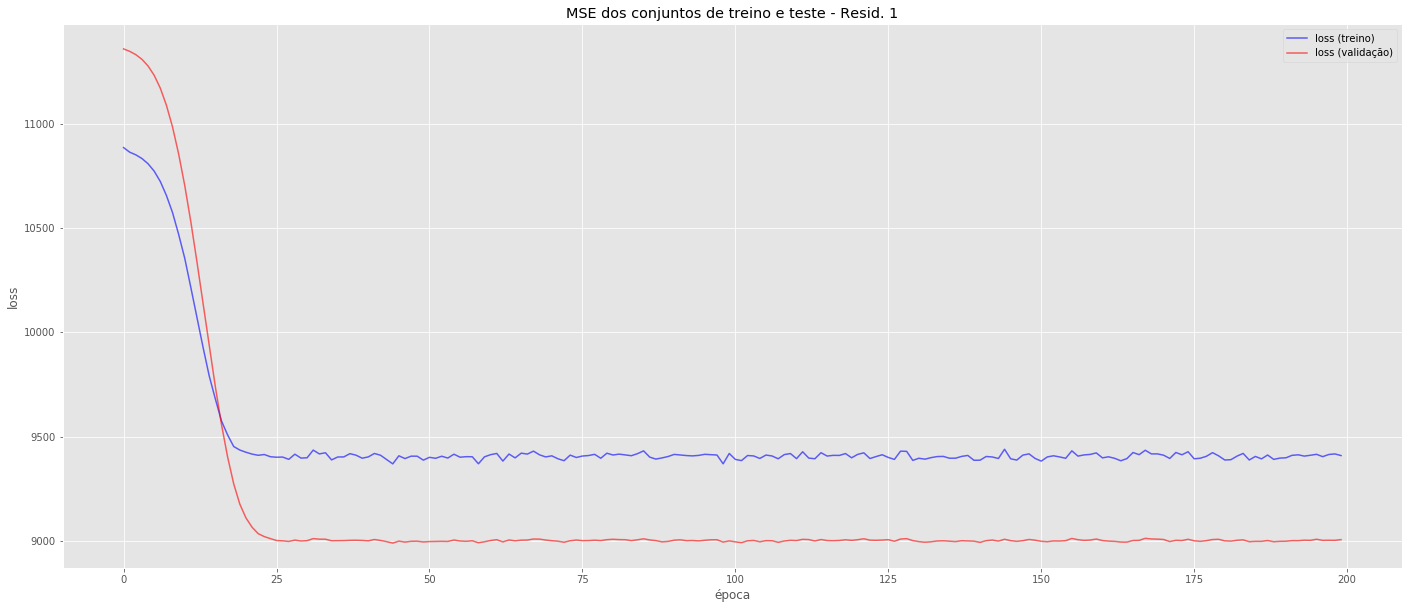

In [53]:
train_loss = hist_fc_1.history['loss']
val_loss = hist_fc_1.history['val_loss']
def plot_losses(train_loss, val_loss):
    plt.rcParams["figure.figsize"] = [24,10]
    plt.title('MSE dos conjuntos de treino e teste - Resid. 1')
    plt.plot( range(len(train_loss)), train_loss, color = 'b', alpha = 0.6, label='loss (treino)' )
    plt.plot( range(len( val_loss )), val_loss, color = 'r', alpha = 0.6, label='loss (validação)' )
    plt.xlabel( 'época' )
    plt.ylabel( 'loss' )
    plt.legend()

plot_losses(train_loss, val_loss)

C:\Users\diego\anaconda3\envs\doutorado\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.


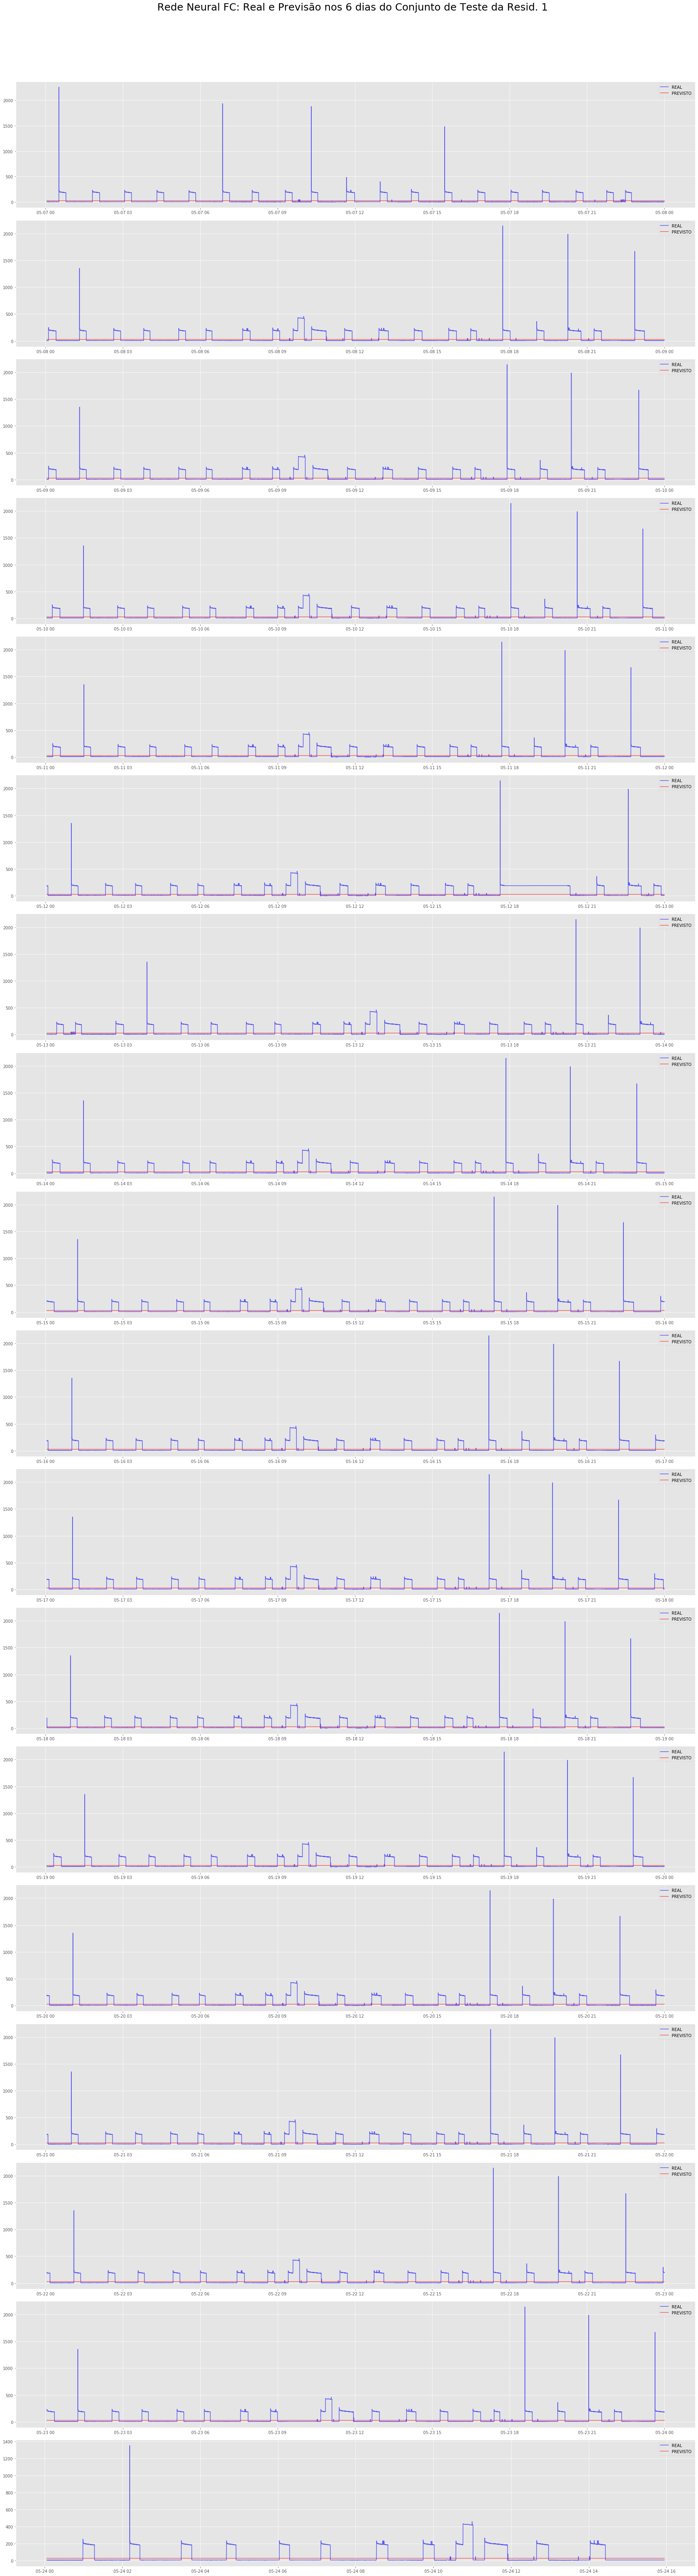

In [59]:
# Plotando os cnsumos REAL e o PREVISTO do refrigerador nos 6 dias dos dados de teste
def plot_each_app(df, dates, predict, y_test, title, look_back = 0):
    num_date = len(dates)
    fig, axes = plt.subplots(num_date,1,figsize=(24, num_date*5) )
    plt.suptitle(title, fontsize = '25')
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    for i in range(num_date):
        if i == 0: l = 0
        ind = df.ix[dates[i]].index[look_back:]
        axes.flat[i].plot(ind, y_test[l:l+len(ind)], color = 'blue', alpha = 0.6, label = 'REAL')
        axes.flat[i].plot(ind, predict[l:l+len(ind)], color = 'red', alpha = 0.6, label = 'PREVISTO')
        axes.flat[i].legend()
        l = len(ind)
plot_each_app(df1_test, dates[17:], pred_fc, y_test, 
              'Rede Neural FC: Real e Previsão nos 6 dias do Conjunto de Teste da Resid. 1', look_back = 50)

In [ ]:
# Testar FC mais complexa

## LSTM

In [67]:
def build_lstm_model(layers):
#         #fc_model.add( Dense(input_dim=layers[i], output_dim= layers[i+1]) )#, W_regularizer=l2(0.1)) )
#         fc_model.add( Dense(input_shape=(layers[i],), units = layers[i+1]) )#, W_regularizer=l2(0.1)) )
#         fc_model.add( Dropout(0.5) )
#         if i < (len(layers) - 2):
#             fc_model.add( Activation('relu') )
    model = Sequential()
    for i in range(len(layers) - 2):
        if i == 0:
            model.add(Embedding(input_dim=layers[i], output_dim=layers[i+1]))
        else:
            model.add(LSTM(
                input_shape=(layers[i],),
                units=layers[i+1],
                return_sequences = True if i < len(layers) - 3 else False ))
            model.add(Dropout(0.3))
    
    model.add(Dense(layers[-1]))
    
    model.build()
    model.summary()
    plot_model(model)
    return model

model = build_lstm_model([2,64,128,256, 1])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          128       
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 128)         98816     
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 256)               394240    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 493,441
Trainable params: 493,441
Non-trainable params: 0
________________________________________________

In [75]:
# Utilizando 50 registros de consumos para retreinar o modelo, e prever o consumo de energia de cada aparelho
def process_data(df, dates, x_features, y_features, look_back = 50):
    i = 0
    for date in dates:
        data = df.loc[date]
        len_data = data.shape[0]
        x = np.array([data[x_features].values[i:i+look_back] 
                      for i in range(len_data - look_back) ]).reshape(-1,look_back, 2)
        y = data[y_features].values[look_back:,:]
        if i == 0:
            X = x
            Y = y
        else:
            X = np.append(X, x, axis=0)
            Y = np.append(Y, y, axis=0)
        i += 1
    return X,Y

start = time.time()
X_train, y_train = process_data(df, dates[:17], ['Mains1','Mains2'], df.columns.values[2:])
X_test, y_test = process_data(df, dates[17:], ['Mains1','Mains2'], df.columns.values[2:])
print('Tempo de execução total (s): ', time.time() - start)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

Tempo de execução total (s):  892.4475183486938
(352010, 50, 2) (352010, 1) (392118, 50, 2) (392118, 1)


In [76]:
start = time.time()
adam = Adam(lr = 5e-5)
lstm_model_path = "./resources/lstm_model.hdf5"
model.compile(loss='mean_squared_error', optimizer=adam)
checkpointer = ModelCheckpoint(filepath=lstm_model_path, verbose=0, save_best_only=True)
hist_lstm = model.fit(
            X_train,
            y_train[:,2],
            batch_size=512,
            verbose=1,
            nb_epoch=200,
            validation_split=0.3,
            callbacks=[checkpointer])
print('Tempo de treino (s): ', time.time() - start)

IndexError: index 2 is out of bounds for axis 1 with size 1

In [71]:
y_train

array([6., 6., 6., ..., 6., 7., 6.], dtype=float32)

# Referências

1. http://nilmtk.github.io/nilmtk